In [125]:
%matplotlib inline
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
from funPytorch import SLoss
from conf import Conf
import torch
from calculate_chi_func import chiCalc_custom
import runExperimentalPredictions

In [126]:
expData = np.load("data/dataset32MCnoB-experimental2021.npz")

expCoh = expData['coh'][0]
expPar = expData['par'][0,0]

In [127]:
def createCoh(y0, a, B, w1, noiseSD = None):
    exceptions = []
    # Parameters of the control field
    #t1_vec = np.arange(0.1, 1.5, 0.002)  # Se va troppo lento usa questo
    # t1_vec = np.arange(0.1,2,0.002) # time vector for t1 [µs]
    # center = 1/(4*0.0010705*B)
    # deltaT = 0.002
    # windowSize = 0.4

    valuesNN = np.array([1, 8, 16, 24, 32, 40, 48])
    t1_vec = np.array([1.65, 1.66, 1.67, 1.68, 1.69, 1.7 , 1.71, 1.72, 1.73, 1.74, 1.75, 1.76, 1.77, 1.78, 1.79, 1.8 , 1.81, 1.82, 1.83,
                       2.75, 2.76, 2.77, 2.78, 2.79, 2.8 , 2.81, 2.82, 2.83, 2.84, 2.85, 2.86, 2.87, 2.88, 2.89, 2.9 , 2.91, 2.92, 2.93, 2.94, 2.95, 2.96, 2.97, 2.98, 2.99, 3.  , 3.01, 3.02, 3.03, 3.04, 3.05])
    #concatenated windows for the 2 collapses: [1.65, 1.83], [2.75, 3.05]; indices: [0, 19), [19, 50)

    allChi = np.zeros((len(valuesNN), len(t1_vec)))
    for indexNN, nN in enumerate(valuesNN):
        totT_vec = 2 * nN * t1_vec  # total time vector [µs]

        # NSD function
        def funcGauss(x, y0, a, xc, w):
            return y0 + a * np.exp(
                -0.5 * ((x - 2 * np.pi * xc) / (2 * np.pi * w)) ** 2)  # I included a couple of 2*np.pi to convert \nu->


        def funcNoise(x, y0, a1, x1, w1):
            return y0 + funcGauss(x, 0, a1, x1,
                                  w1)  # + funcGauss(x,0,a2,x2,w2) + funcGauss(x,0,a3,x3,w3) + funcGauss(x,0,a4,x4,w4)


        ## Function to calculate the distribution of pi pulses for a CPMG sequence
        def cpmg(t1, nN):
            seq = np.ones(nN + 1) * 2 * t1
            seq[0] = t1
            seq[-1] = t1  # [-1] indica l'elemento finale del vettore
            return seq


        # showPlot = True  # False #
        # saveData = False  # True #

        # NSD parameters
        vl = B * 1.0705e-3  # B*\gamma [MHZ]
        para = np.array([y0, a, vl, w1])  # [offset, amplitude, center, width] all in MHz

        ## Calculate chi at every total time
        chi = np.zeros(len(totT_vec))

        for i, totT in enumerate(totT_vec):
            ## Time between pulses
            t1 = totT / (2 * nN)

            ## pi pulses distribution
            pulses_times = cpmg(t1, nN).cumsum()[:-1]  # [:-1] <--- del vettore considerato si prendono tutti i valori all'infuori dell'ultimo

            ## Calculate chi
            try:
                chi[i] = chiCalc_custom(funcNoise, para, totT, pulses_times)
            except Exception as e:
                exceptions.append((i, t1, e))

        allChi[indexNN] = np.exp(-chi)

    # parString = "{}_{}_{}_{}".format(y0, a, B, w1)

    # return np.float32(np.exp(-chi)), parString
    parameters = np.array([y0, a, B, w1])

    if len(exceptions)>0:
        print(exceptions)

    if not noiseSD is None:
        allChi += np.random.normal(0, noiseSD, allChi.shape)

    return valuesNN, t1_vec, allChi

In [128]:
def createS(y0, a, B, w1):
    def funcGauss(x,y0, a,xc,w):
        return y0+a*np.exp(-0.5*((x-2*np.pi*xc)/(2*np.pi*w))**2) #I included a couple of 2*np.pi to convert \nu->

    def funcNoise(x,y0,a1,x1,w1): # ,a2,x2,w2 ,a3,x3,w3 ,a4,x4,w4):
        return y0 + funcGauss(x,0,a1,x1,w1) #+ funcGauss(x,0,a2,x2,w2) + funcGauss(x,0,a3,x3,w3) + funcGauss(x,0,a4,x4,w4)

    γ=1.0705e-3 # C-13 nuclear spin gyromagnetic ratio

    omega2 = 2*np.pi*np.linspace(γ*B-5*w1, γ*B+5*w1,500)
    # omega2 = 2*np.pi*np.linspace(0.001, 8.5, 100000)

    νl = B*γ # B*\gamma [MHZ]
    # para_A=np.array([0.0, a,νl,w1]) # [offset, amplitude, center, width] All in MHz
    para_A=np.array([y0, a,νl,w1]) # [offset, amplitude, center, width] All in MHz
    S = funcNoise(omega2,*para_A)

    return omega2, S

In [129]:
def L(p, y):
    fakeConf = Conf({"fixedB": 403.2, "normalizeY": False})
    device = "cpu"
    loss = SLoss(fakeConf, device)
    return loss(torch.tensor(p).view(1,-1), torch.tensor(y).view(1,-1)).item()

# Compare with real data

In [130]:
# pred = runExperimentalPredictions.run("configMCRnew2L2")
# pred = runExperimentalPredictions.run("configMCRnew2L2_10k")
# pred = runExperimentalPredictions.run("configMCRnew2")
# pred = runExperimentalPredictions.run("configMCRnew2_10000")
#============================
# pred = [
#     runExperimentalPredictions.run("configMCRnew2cL2norm"),
#     runExperimentalPredictions.run("configMCRnew2bL2norm"),
#     runExperimentalPredictions.run("configMCRnew2b3L2norm"), #few err
#     runExperimentalPredictions.run("configMCRnew2b4L2norm"),
#     runExperimentalPredictions.run("configMCRnew2b5L2norm"),
#     runExperimentalPredictions.run("configMCRnew2b6L2norm"),
#     runExperimentalPredictions.run("configMCRnew2L2norm"),
# ]
# plotNames = {
#     "L" : "plots/expL.pdf",
#     "MAE" : "plots/expMAE.pdf",
#     "MAEf" : "plots/expMAEf.pdf",
#     "SC" : "plots/expSC-N{}.pdf",
#     "DIST" : "plots/expDist.pdf",
# }
#============================
pred = [
    runExperimentalPredictions.run("configMCRnew2cL2norm10k"),
    runExperimentalPredictions.run("configMCRnew2bL2norm10k"),
    runExperimentalPredictions.run("configMCRnew2b3L2norm10k"),
    runExperimentalPredictions.run("configMCRnew2b4L2norm10k"),
    runExperimentalPredictions.run("configMCRnew2b5L2norm10k"),
    runExperimentalPredictions.run("configMCRnew2b6L2norm10k"),
    runExperimentalPredictions.run("configMCRnew2L2norm10k"),
]
plotNames = {
    "L" : "plots/expL10k.pdf",
    "MAE" : "plots/expMAE10k.pdf",
    "MAEf" : "plots/expMAEf10k.pdf",
    "SC" : "plots/expSC10k-N{}.pdf",
    "DIST" : "plots/expDist10k.pdf",
}

pred = np.array([[pred[i][0, 0], pred[i][0, 1], 403.2, pred[i][0, 2]] for i in range(len(pred))])

In [131]:
print(expPar)
print(pred)

[1.190e-03 5.200e-01 4.037e+02 4.200e-03]
[[2.22653733e-03 4.99687970e-01 4.03200000e+02 5.48575167e-03]
 [8.49534292e-04 6.46449685e-01 4.03200000e+02 4.44890652e-03]
 [7.96314096e-04 7.38445103e-01 4.03200000e+02 3.22316284e-03]
 [5.29166020e-04 8.01444173e-01 4.03200000e+02 3.41789750e-03]
 [9.23019485e-04 8.20414305e-01 4.03200000e+02 3.18348315e-03]
 [8.37818137e-04 8.03803086e-01 4.03200000e+02 3.43925320e-03]
 [5.75278711e-04 7.38539279e-01 4.03200000e+02 3.46647017e-03]]


In [132]:
pred.tofile("/tmp/nsd_params_ML_10k.csv", sep=',',format='%5.20f')

/home/trianam/Progetti/nvSensing/calculate_chi_func.py:51: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = np.abs(quad( lambda x: np.abs(funcNoise(x,*para)*Fn(x,t)/(np.pi*x**2)), 0.001, 8.5)) # integrate from ω=0.001 to ω=8.5


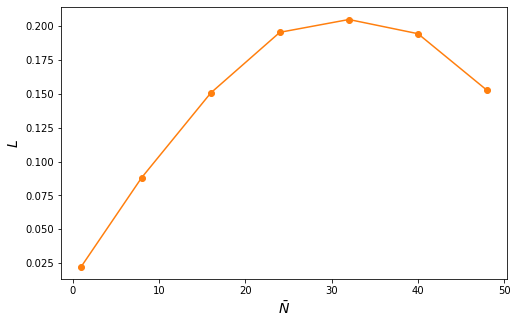

In [133]:
predNN, _, _ = createCoh(pred[0,0], pred[0,1], pred[0,2], pred[0,3])

fig = plt.figure(figsize=(8,5))
plt.plot(predNN, [L(pred[i], expPar) for i in range(len(pred))], color='C1', marker='o')
plt.xlabel(r'$\bar{N}$',fontsize=14)
plt.ylabel(r'$L$',fontsize=14)
plt.show()
fig.savefig(plotNames['L'], bbox_inches='tight')

In [134]:
# 1k:  [0.029044130666181445, 0.050702374337241056, 0.19301948098884897 , 0.20632074096845462, 0.21123306369176134, 0.23545761235069948, 0.22983528040989767]
# 10k: [..., 0.08818212016741746, 0.15068396905716508, 0.19544594126398443, 0.20489477402938064, 0.19441486618958878, 0.15262568501458737]

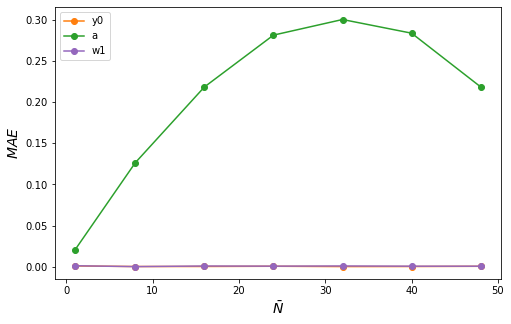

In [135]:
fig = plt.figure(figsize=(8,5))
plt.plot(predNN, [np.abs(pred[i][0] - expPar[0]) for i in range(len(pred))], color='C1', marker='o', label="y0")
plt.plot(predNN, [np.abs(pred[i][1] - expPar[1]) for i in range(len(pred))], color='C2', marker='o', label="a")
# plt.plot(predNN, [np.abs(pred[i][2] - expPar[2]) for i in range(len(pred))], color='C3', marker='o', label="B")
plt.plot(predNN, [np.abs(pred[i][3] - expPar[3]) for i in range(len(pred))], color='C4', marker='o', label="w1")
plt.xlabel(r'$\bar{N}$',fontsize=14)
plt.ylabel(r'$MAE$',fontsize=14)
plt.legend()
plt.show()
fig.savefig(plotNames['MAEf'], bbox_inches='tight')

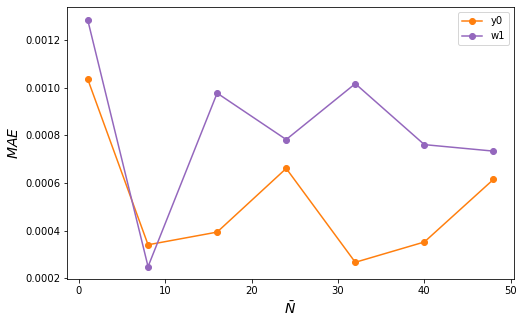

In [136]:
fig = plt.figure(figsize=(8,5))
plt.plot(predNN, [np.abs(pred[i][0] - expPar[0]) for i in range(len(pred))], color='C1', marker='o', label="y0")
# plt.plot(predNN, [np.abs(pred[i][1] - expPar[1]) for i in range(len(pred))], color='C2', marker='o', label="a")
# plt.plot(predNN, [np.abs(pred[i][2] - expPar[2]) for i in range(len(pred))], color='C3', marker='o', label="B")
plt.plot(predNN, [np.abs(pred[i][3] - expPar[3]) for i in range(len(pred))], color='C4', marker='o', label="w1")
plt.xlabel(r'$\bar{N}$',fontsize=14)
plt.ylabel(r'$MAE$',fontsize=14)
plt.legend()
plt.show()
fig.savefig(plotNames['MAE'], bbox_inches='tight')

/home/trianam/Progetti/nvSensing/calculate_chi_func.py:51: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = np.abs(quad( lambda x: np.abs(funcNoise(x,*para)*Fn(x,t)/(np.pi*x**2)), 0.001, 8.5)) # integrate from ω=0.001 to ω=8.5


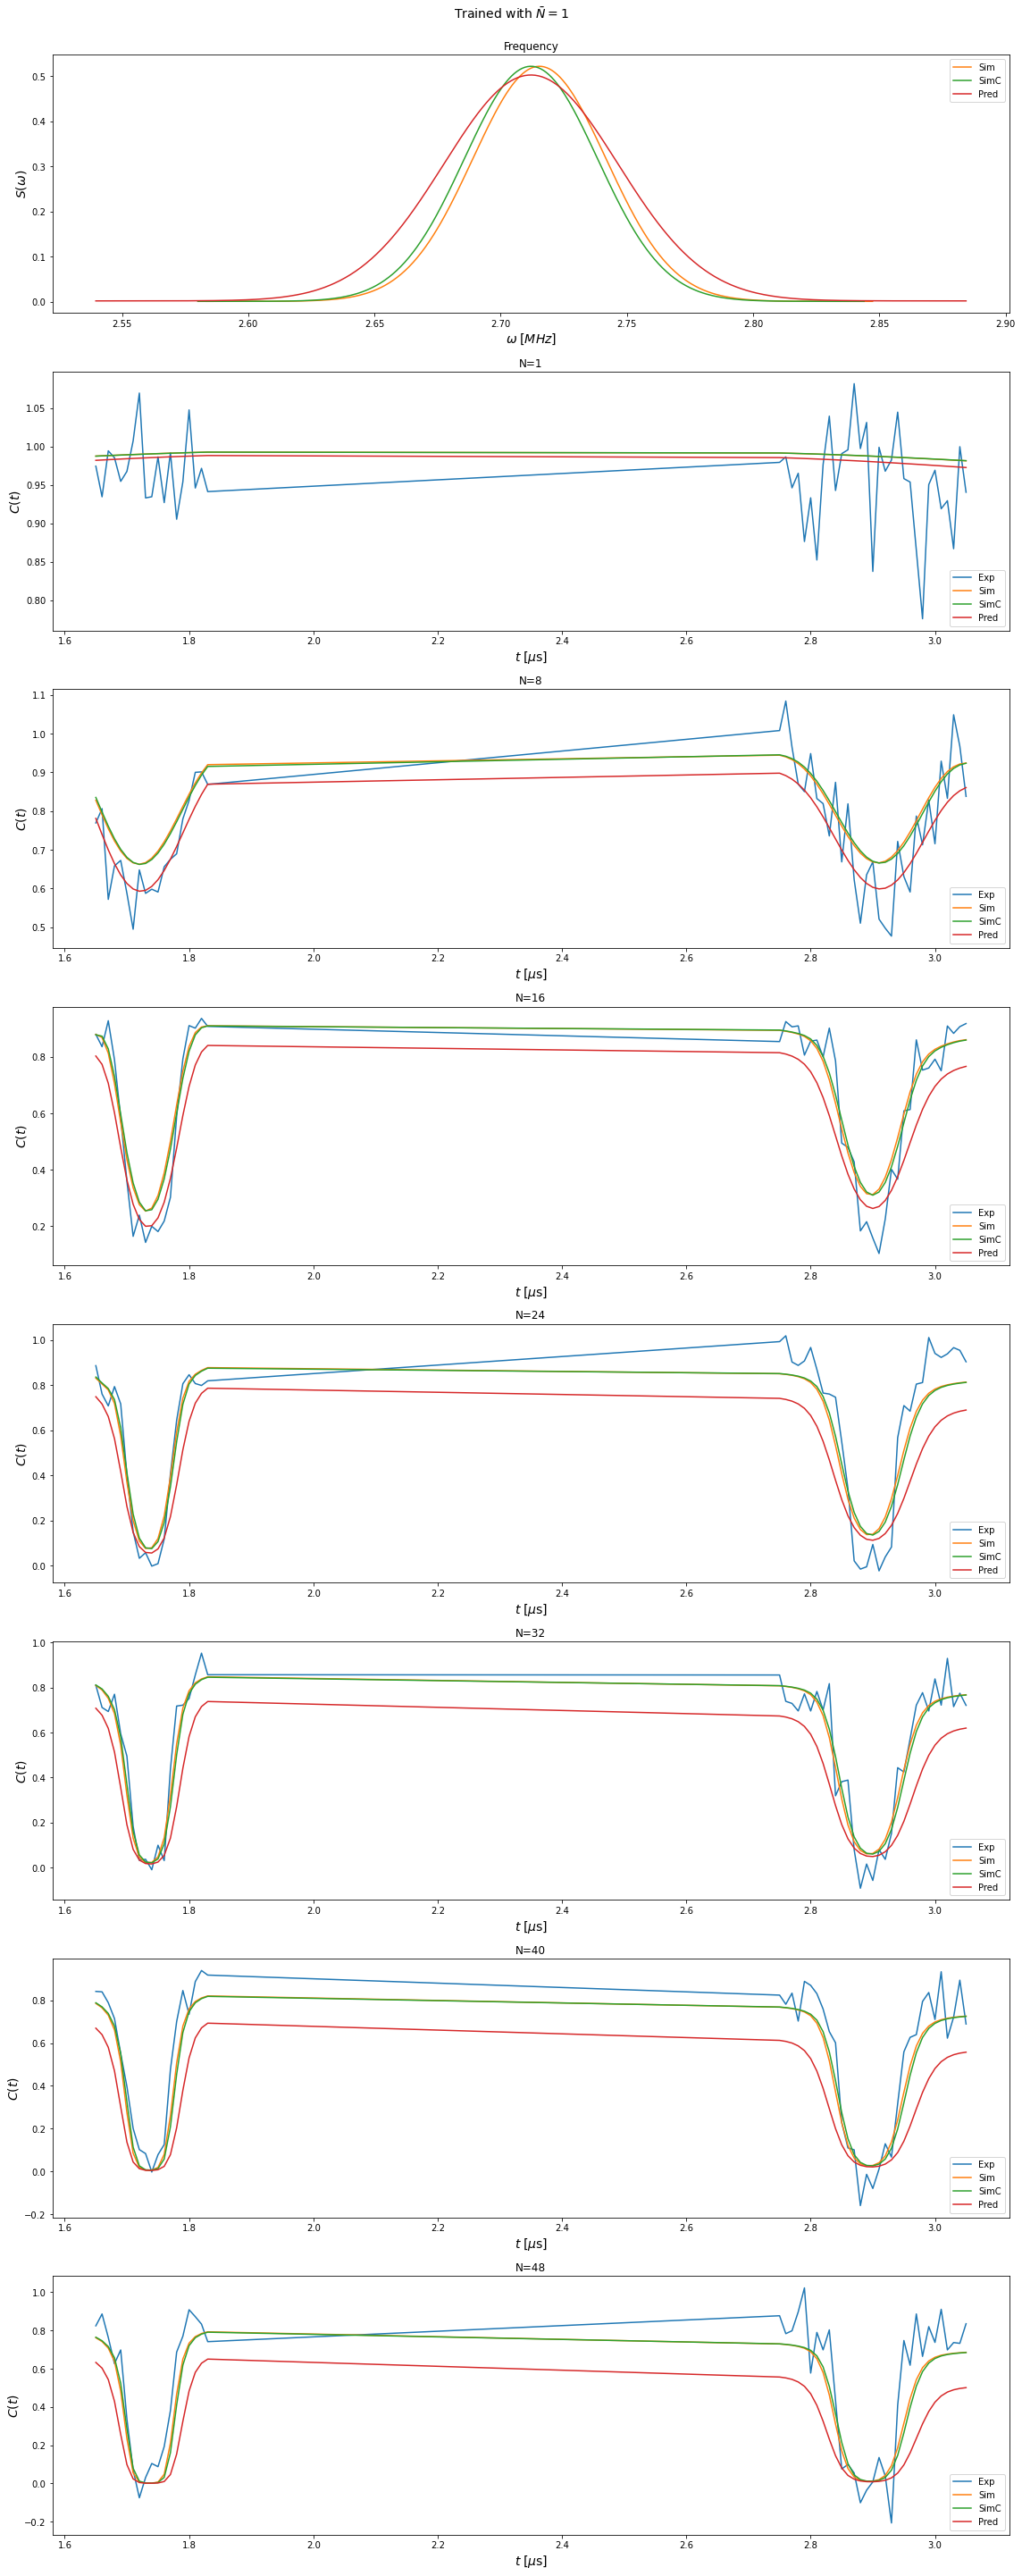

/home/trianam/Progetti/nvSensing/calculate_chi_func.py:51: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = np.abs(quad( lambda x: np.abs(funcNoise(x,*para)*Fn(x,t)/(np.pi*x**2)), 0.001, 8.5)) # integrate from ω=0.001 to ω=8.5


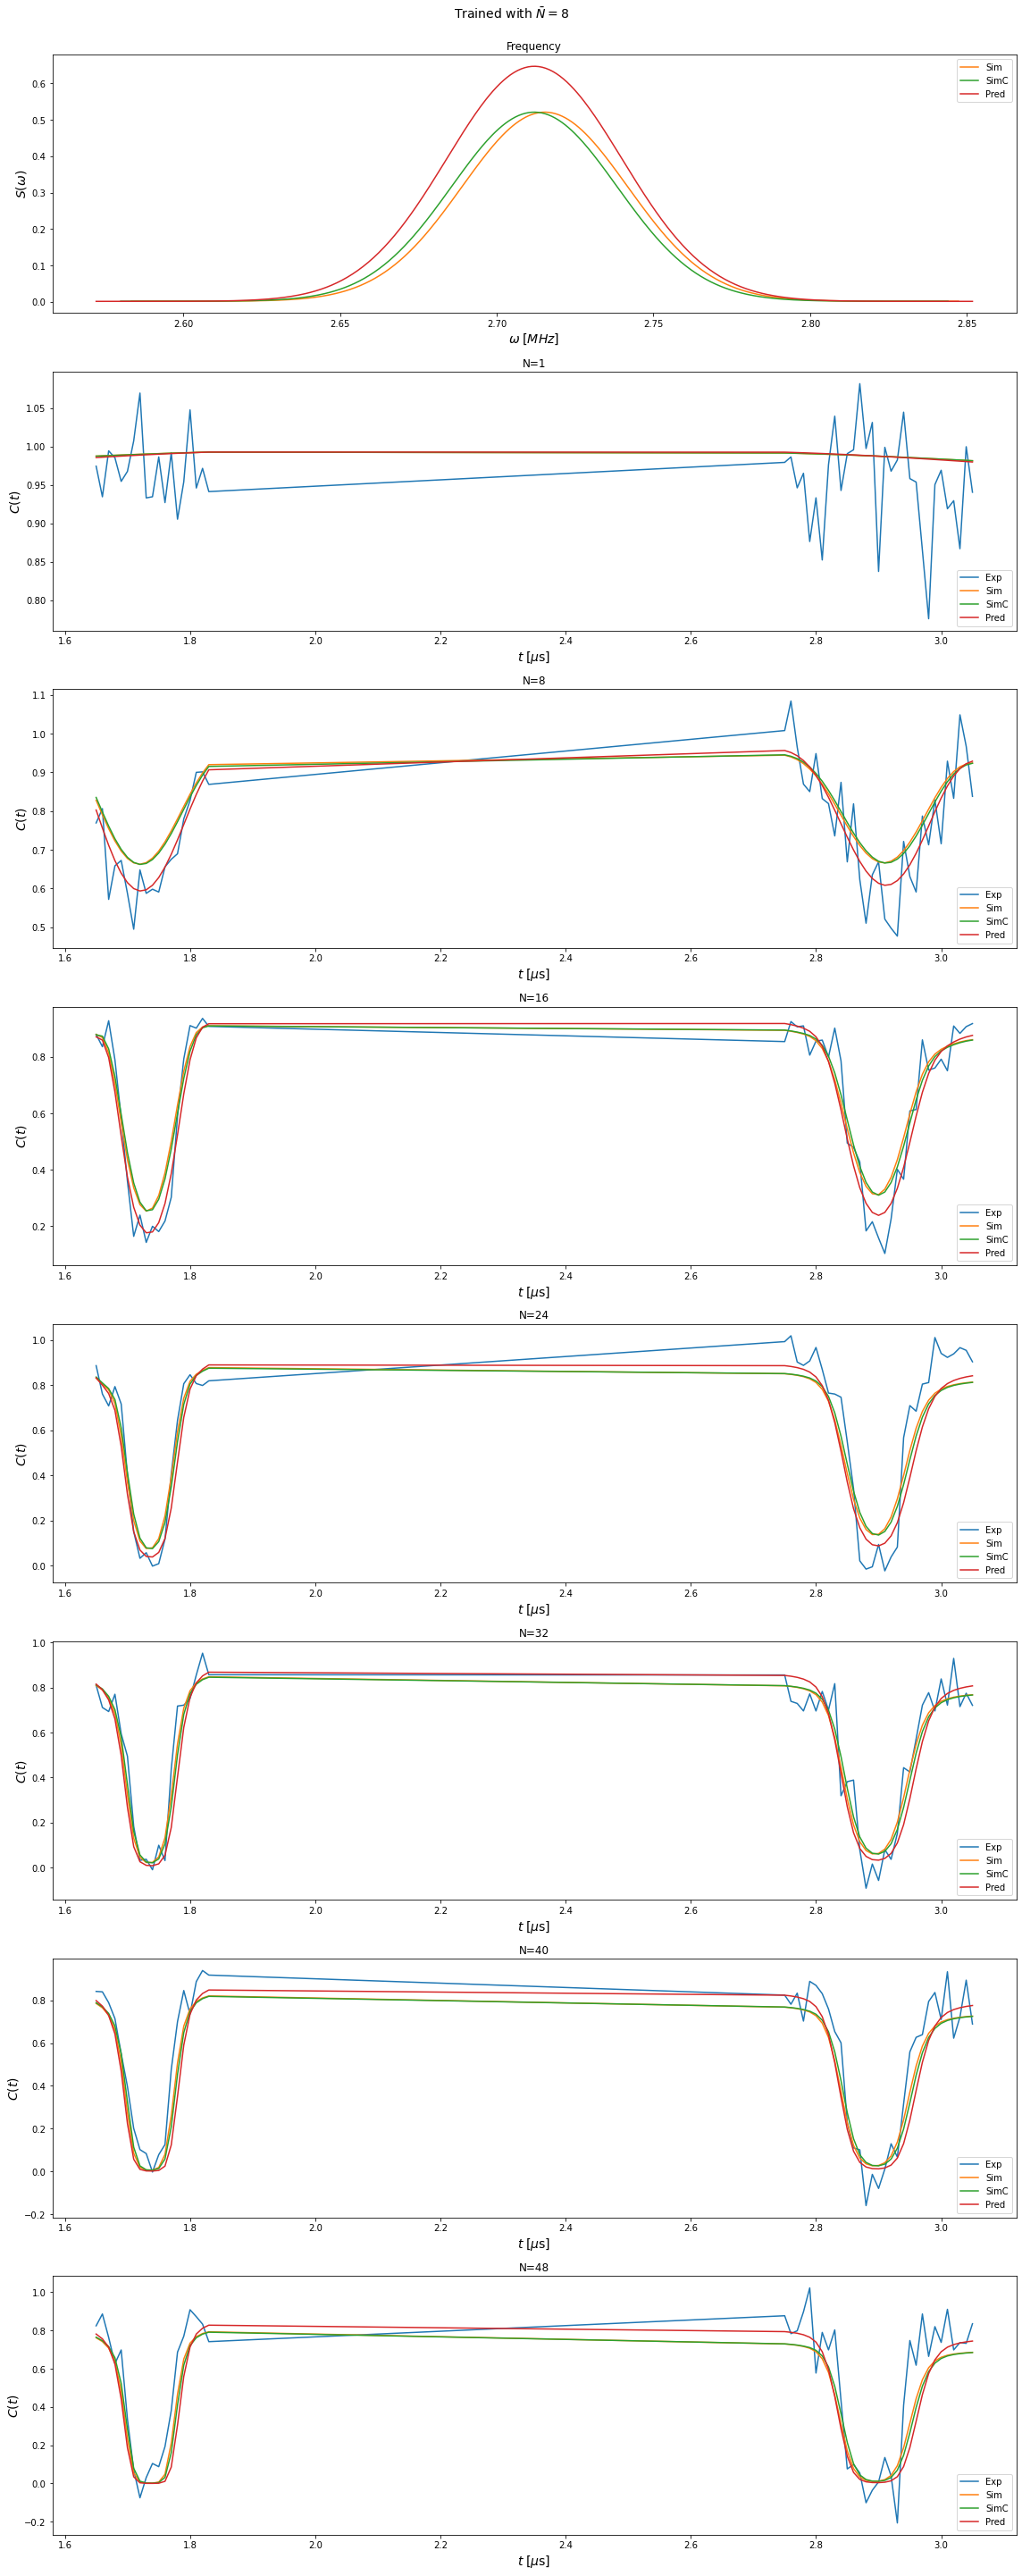

/home/trianam/Progetti/nvSensing/calculate_chi_func.py:51: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = np.abs(quad( lambda x: np.abs(funcNoise(x,*para)*Fn(x,t)/(np.pi*x**2)), 0.001, 8.5)) # integrate from ω=0.001 to ω=8.5


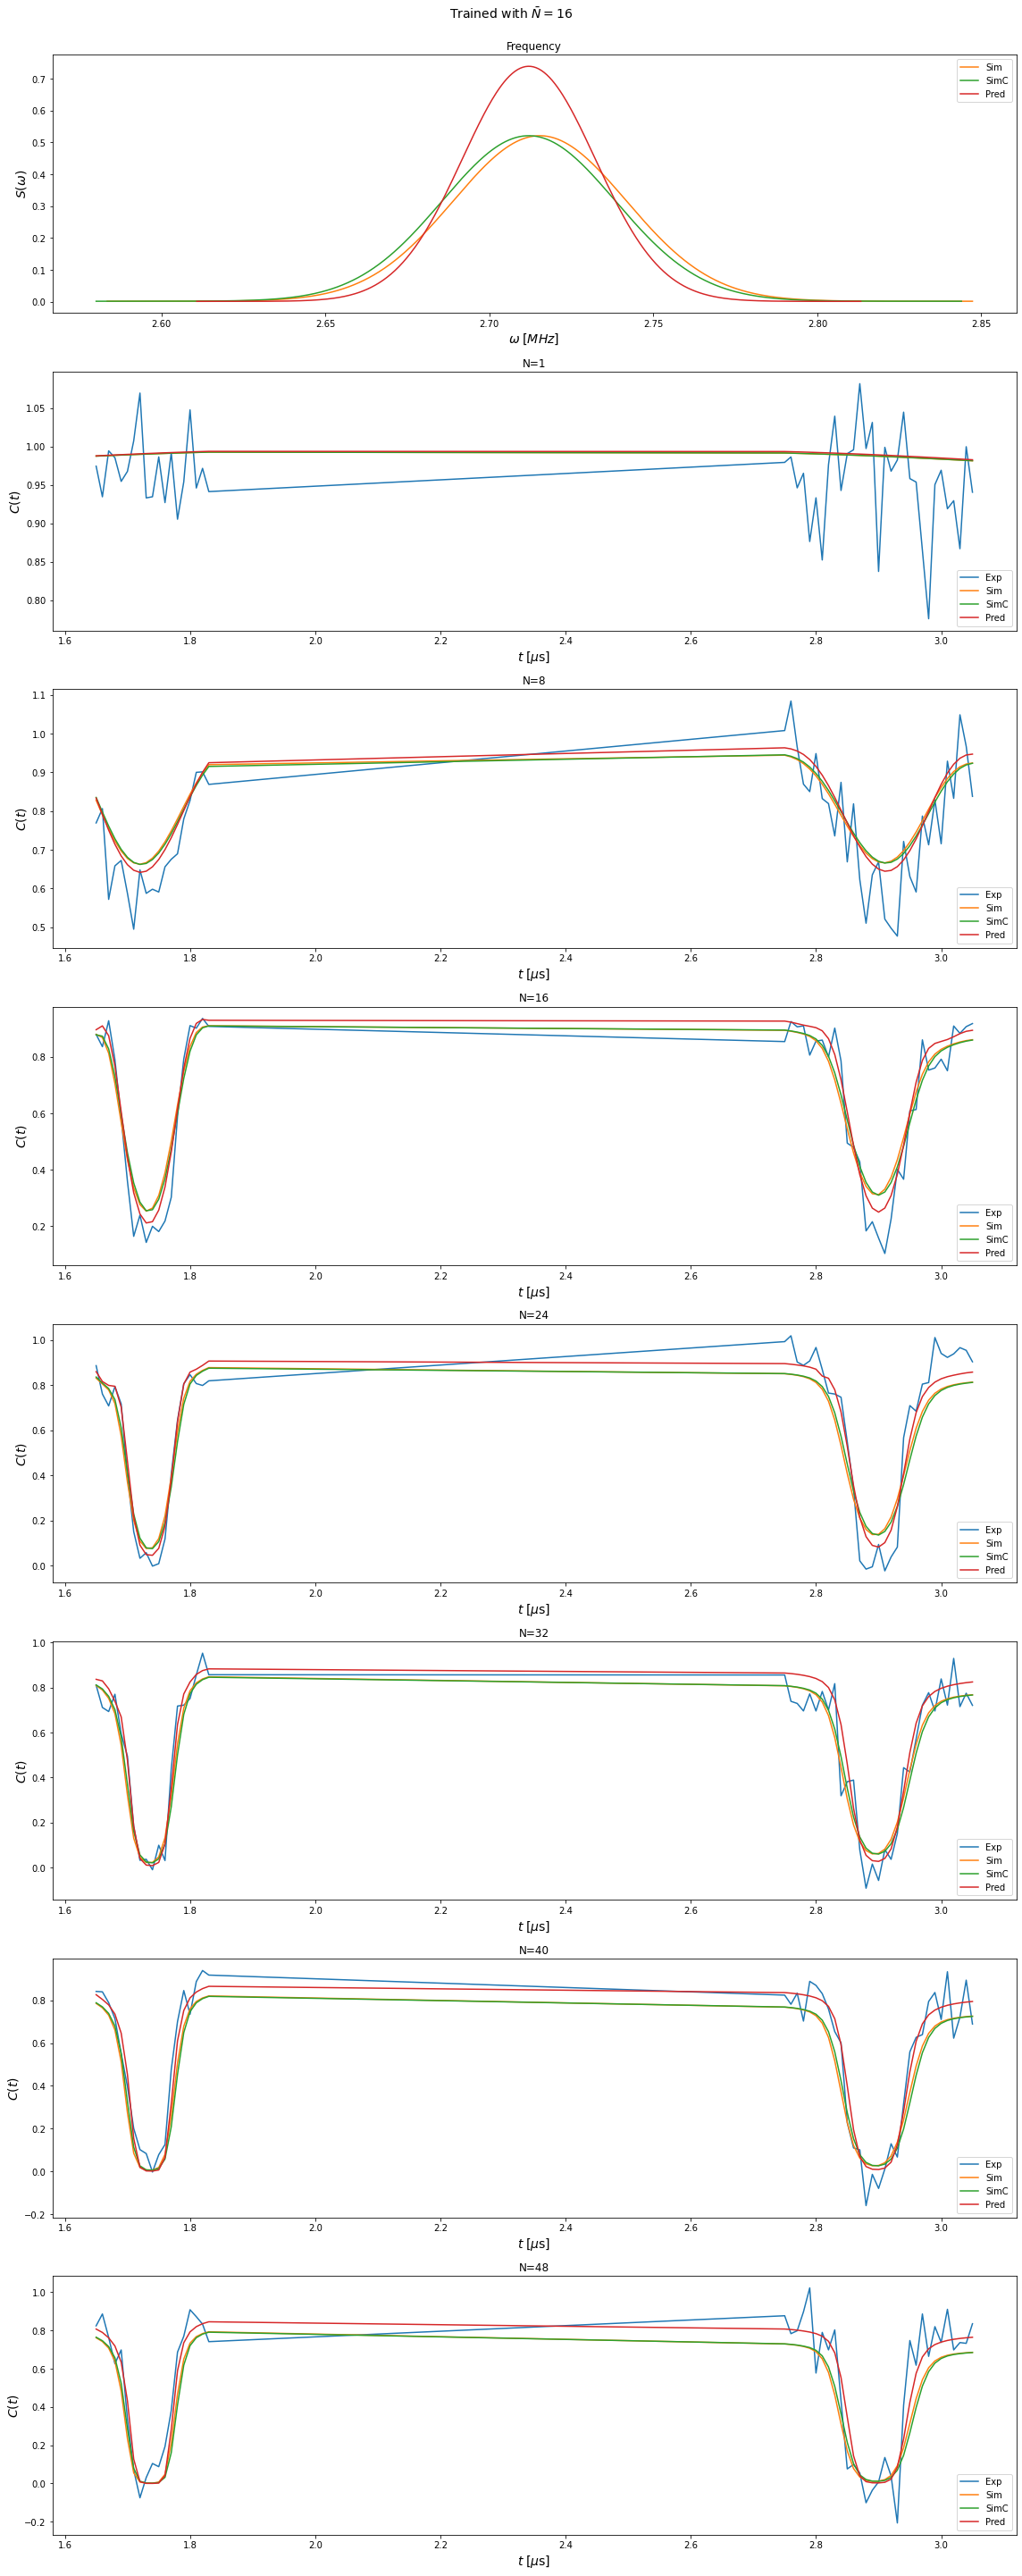

/home/trianam/Progetti/nvSensing/calculate_chi_func.py:51: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = np.abs(quad( lambda x: np.abs(funcNoise(x,*para)*Fn(x,t)/(np.pi*x**2)), 0.001, 8.5)) # integrate from ω=0.001 to ω=8.5


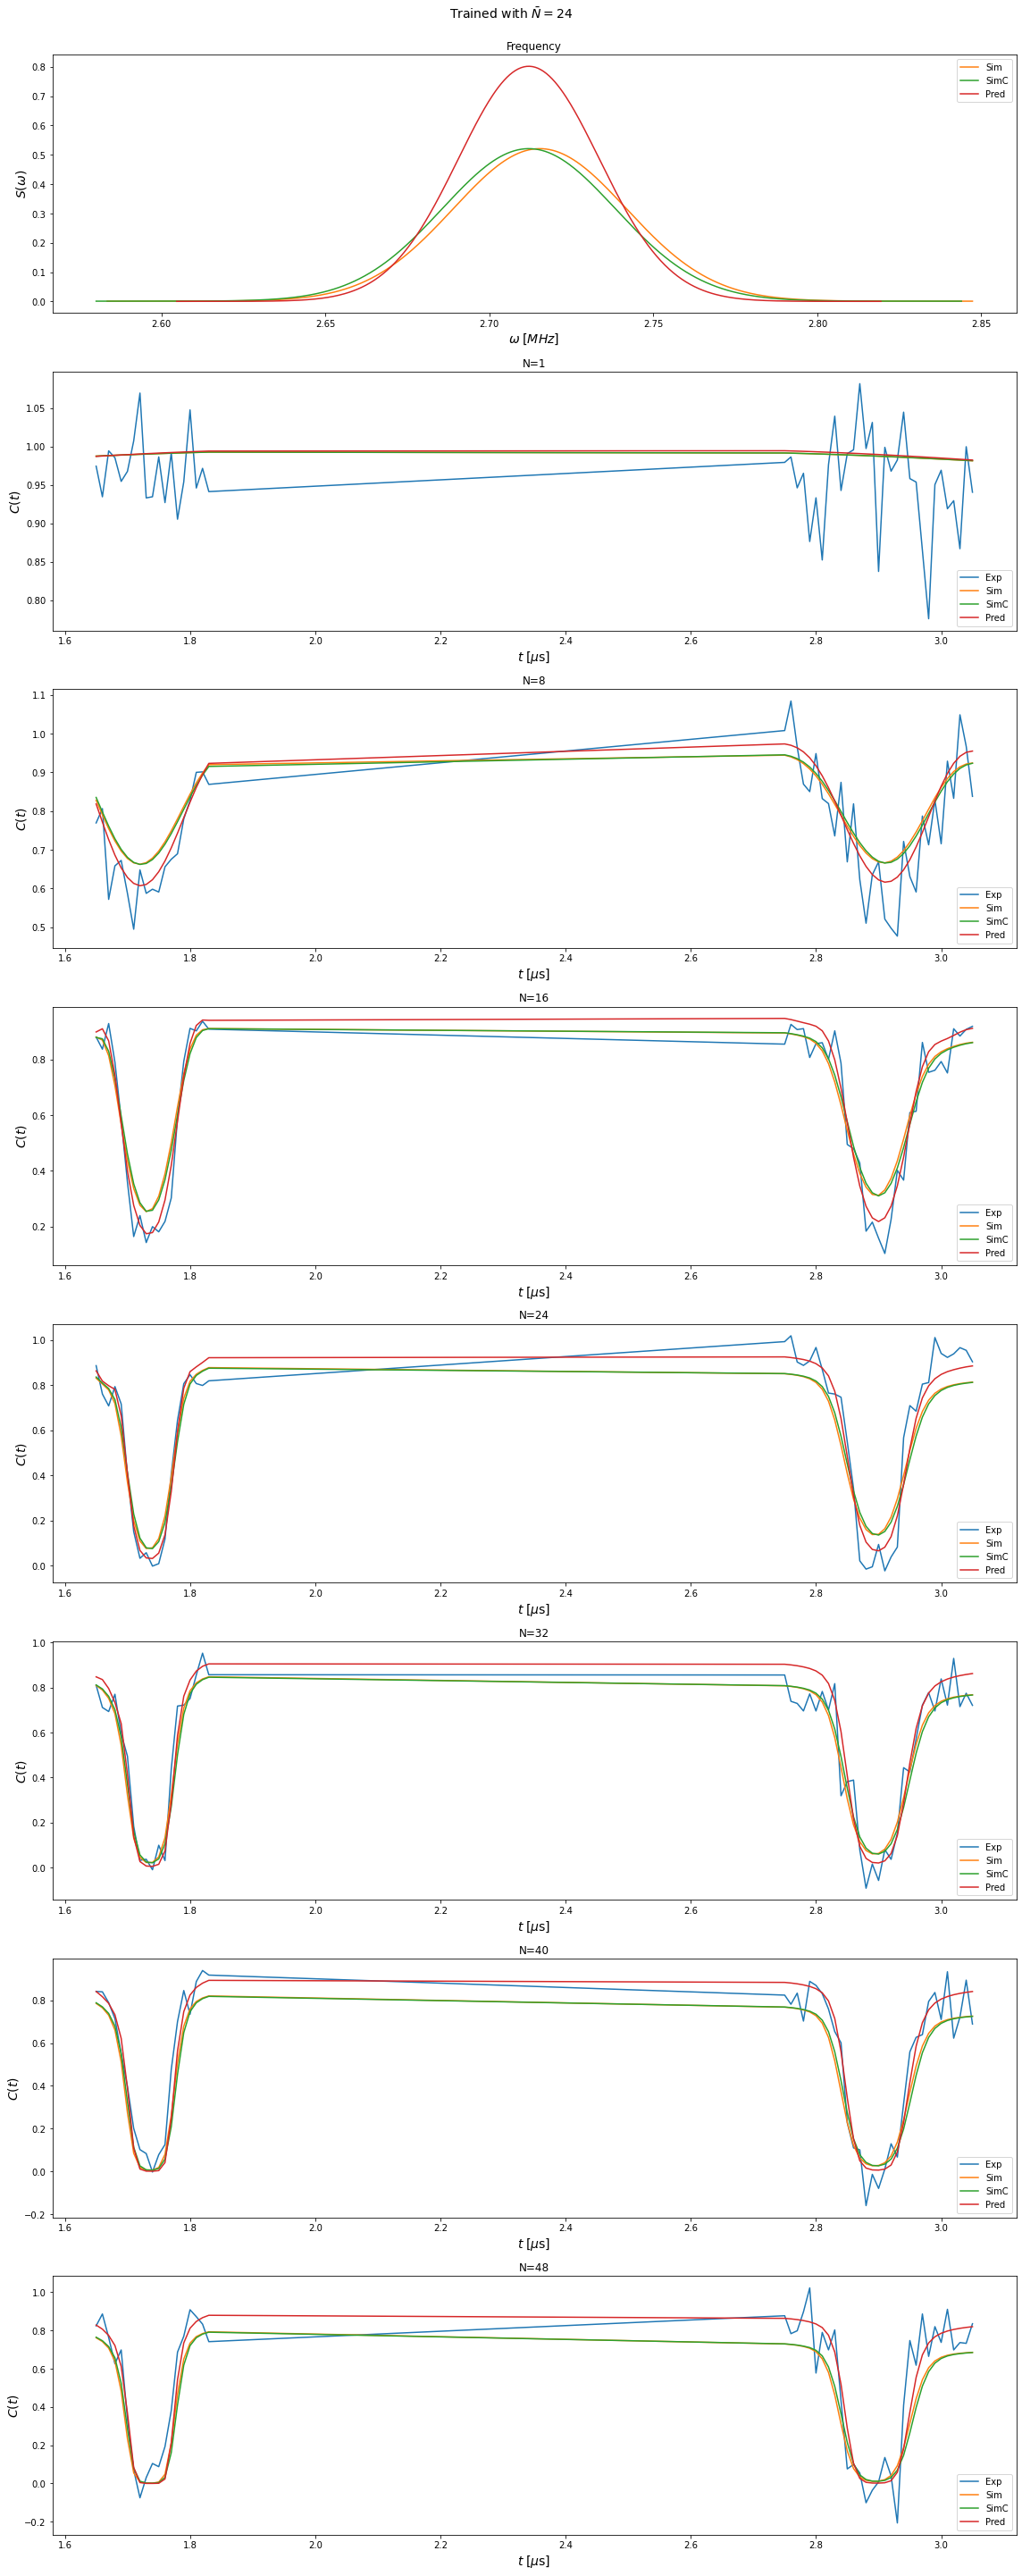

/home/trianam/Progetti/nvSensing/calculate_chi_func.py:51: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = np.abs(quad( lambda x: np.abs(funcNoise(x,*para)*Fn(x,t)/(np.pi*x**2)), 0.001, 8.5)) # integrate from ω=0.001 to ω=8.5


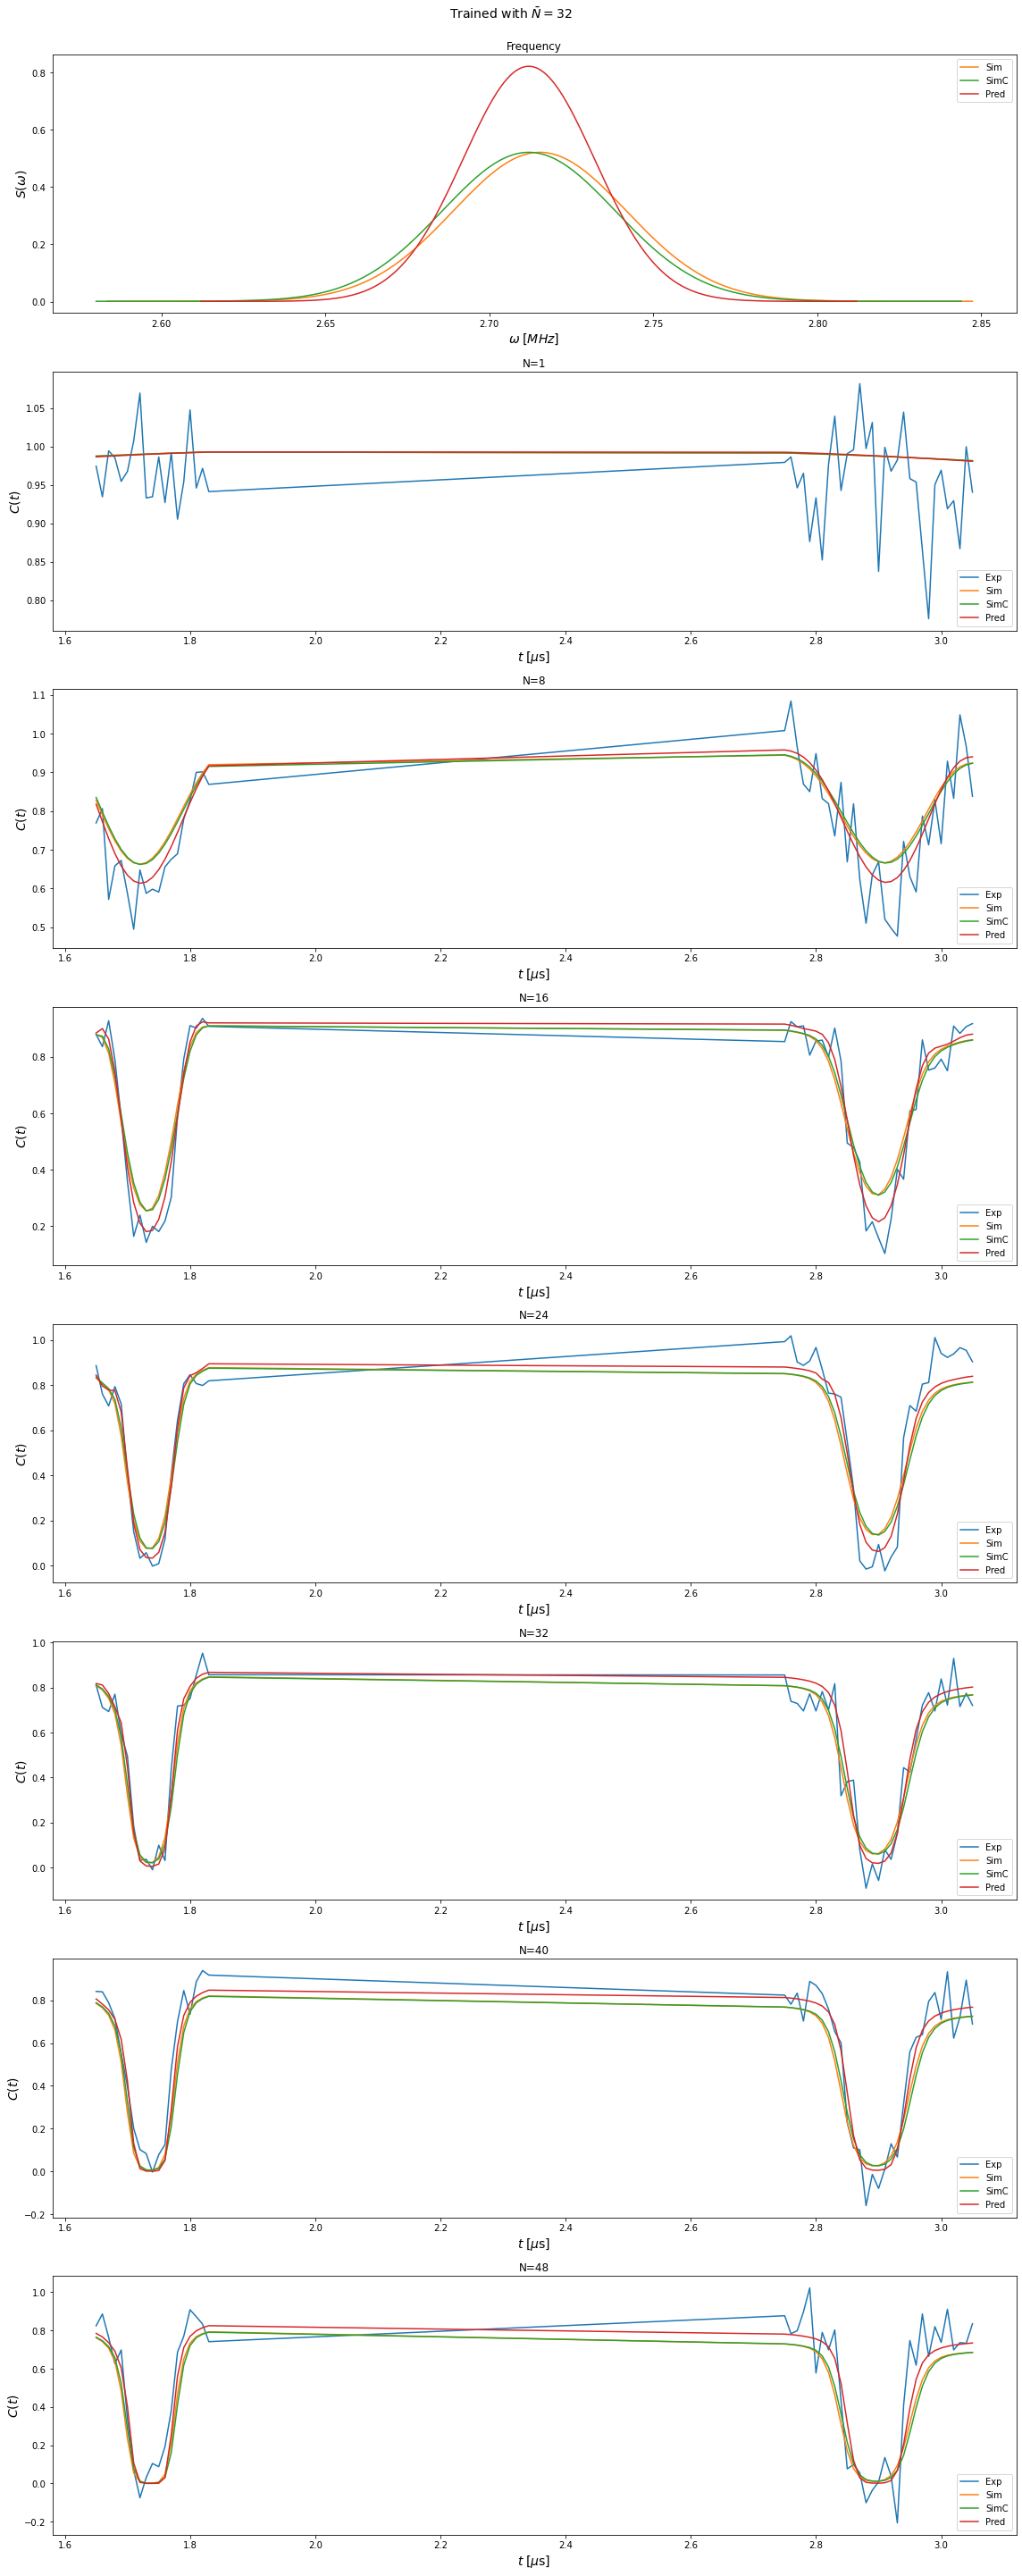

/home/trianam/Progetti/nvSensing/calculate_chi_func.py:51: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = np.abs(quad( lambda x: np.abs(funcNoise(x,*para)*Fn(x,t)/(np.pi*x**2)), 0.001, 8.5)) # integrate from ω=0.001 to ω=8.5


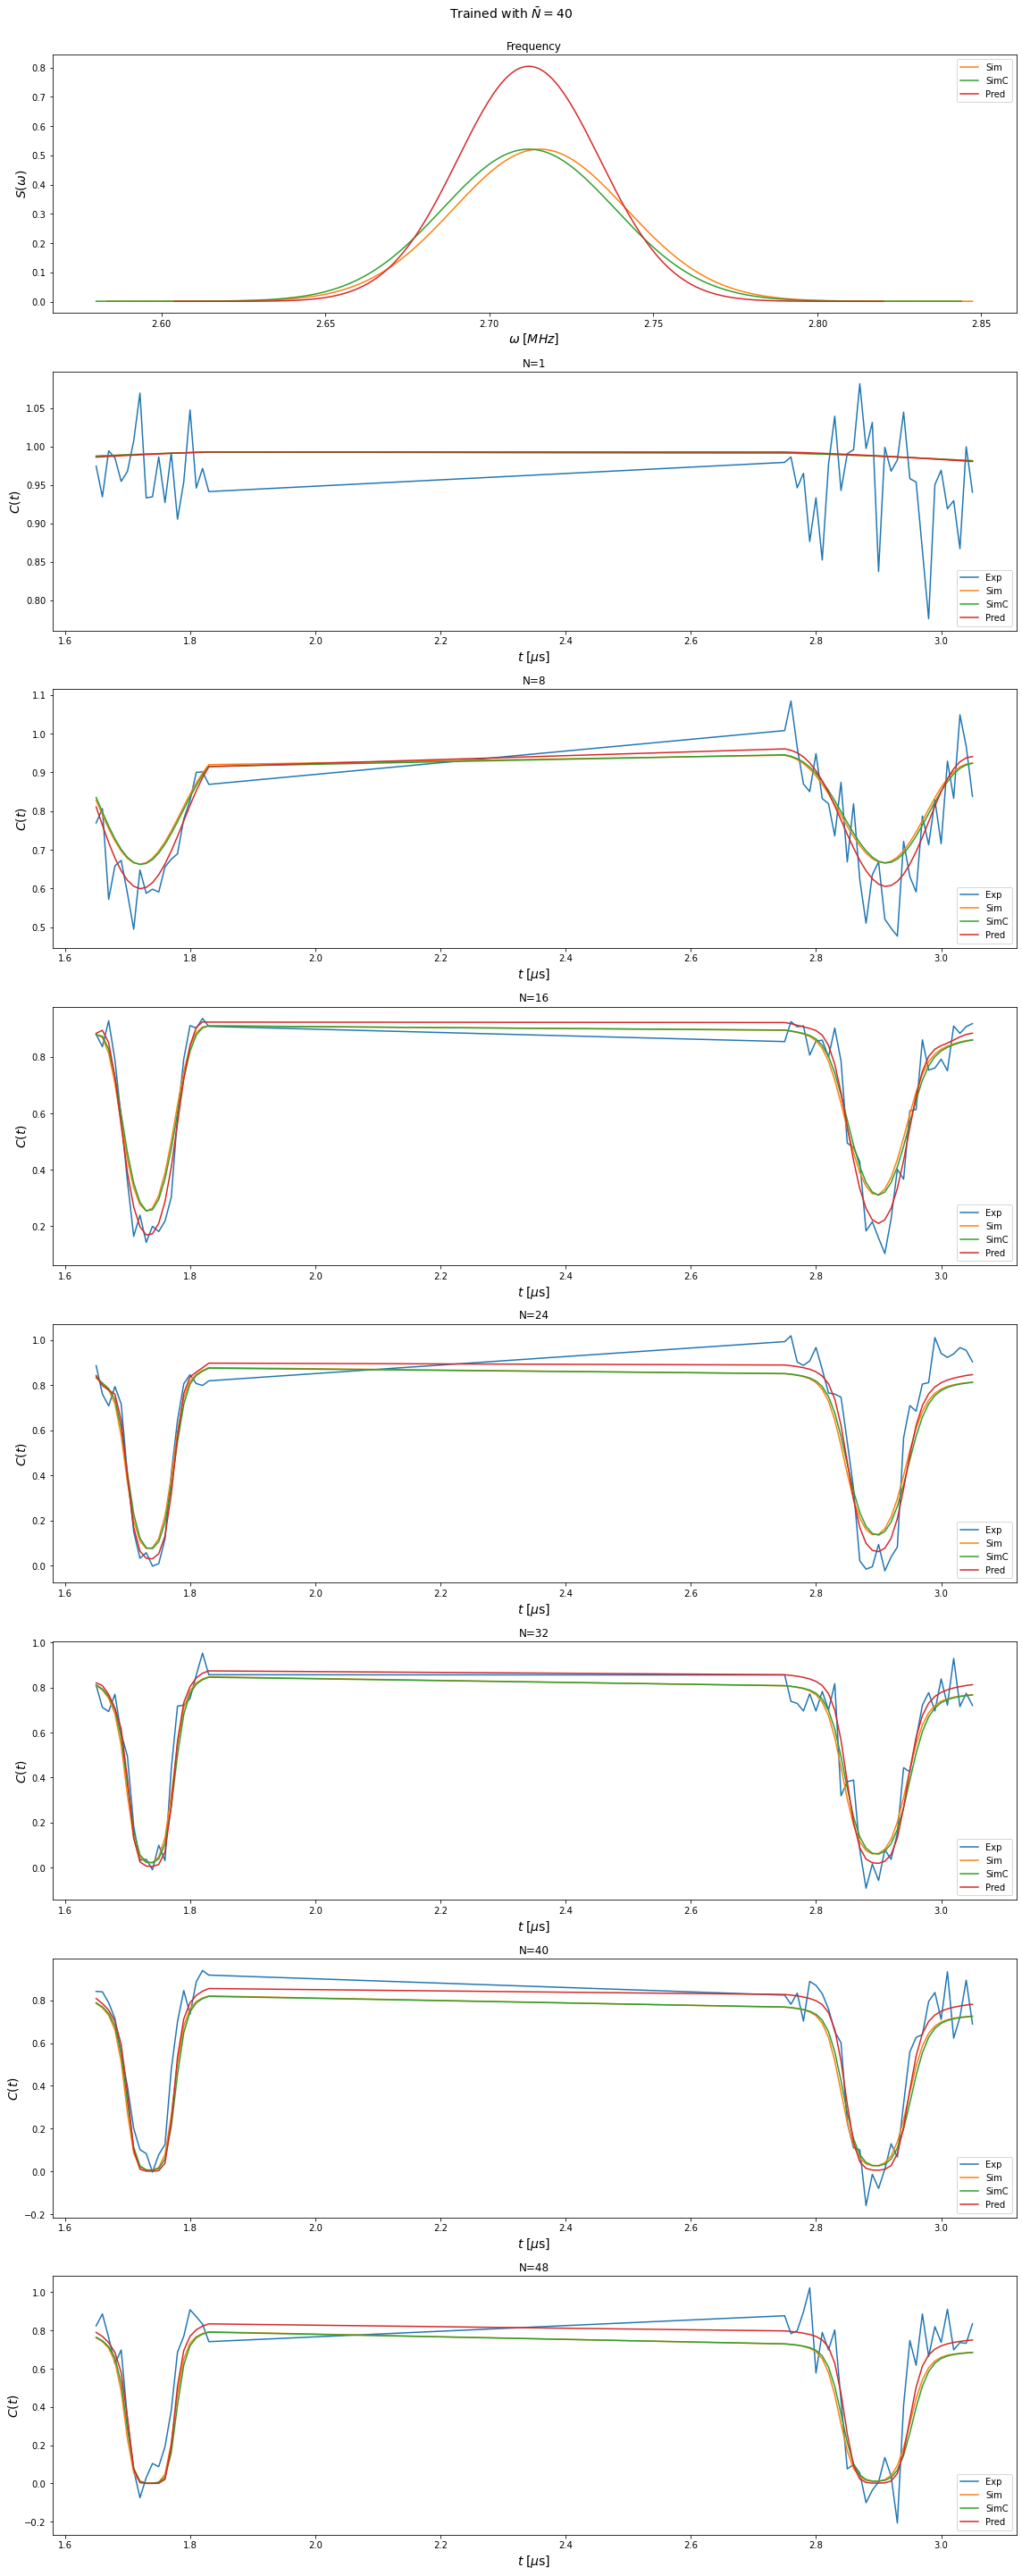

/home/trianam/Progetti/nvSensing/calculate_chi_func.py:51: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = np.abs(quad( lambda x: np.abs(funcNoise(x,*para)*Fn(x,t)/(np.pi*x**2)), 0.001, 8.5)) # integrate from ω=0.001 to ω=8.5


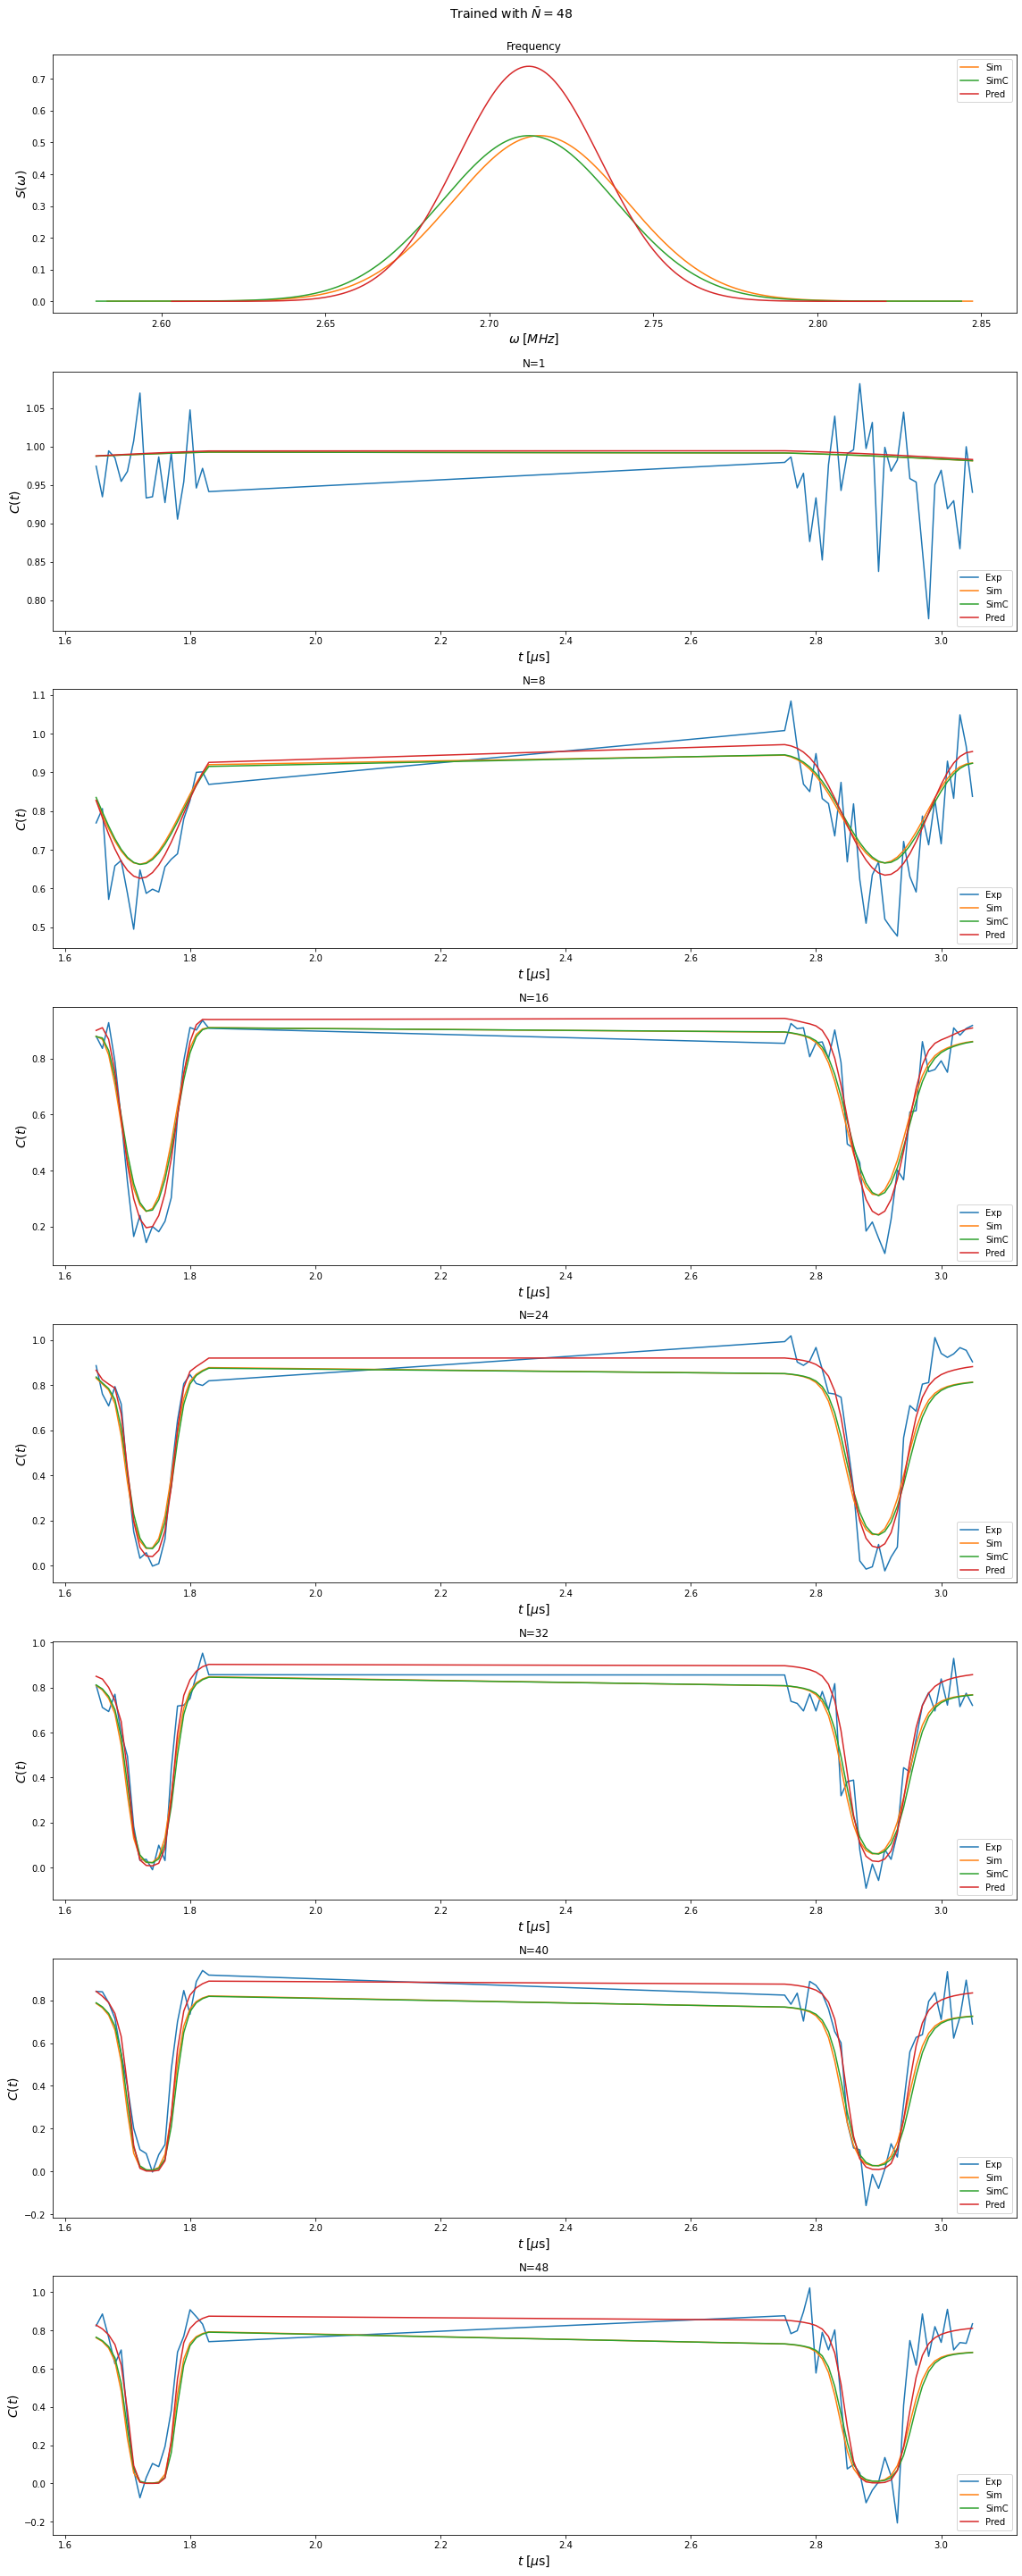

In [137]:
# noiseSD = 0.05
noiseSD = None

simNN, simT1, simCoh = createCoh(expPar[0], expPar[1], expPar[2], expPar[3], noiseSD)
simNNC, simT1C, simCohC = createCoh(expPar[0], expPar[1], 403.2, expPar[3], noiseSD)

avgSimDists = []
avgPredDists = []
for Nb in range(len(pred)):
    predNN, predT1, predCoh = createCoh(pred[Nb,0], pred[Nb,1], pred[Nb,2], pred[Nb,3], noiseSD)

    expO, expS = createS(expPar[0], expPar[1], expPar[2], expPar[3])
    expCO, expCS = createS(expPar[0], expPar[1], 403.2, expPar[3])
    predO, predS = createS(pred[Nb,0], pred[Nb,1], pred[Nb,2], pred[Nb,3])

    fig, axes = plt.subplots(1+len(simCoh), 1, figsize=(16,5*(1+len(simCoh))))
    # fig.subplots_adjust(top=0.8)
    fig.suptitle(r'Trained with $\bar{{N}}={}$'.format(simNN[Nb]), fontsize=14, y=1)

    axes[0].plot(expO, expS, label="Sim", color='C1')
    axes[0].plot(expCO, expCS, label="SimC", color='C2')
    axes[0].plot(predO, predS, label="Pred", color='C3')
    axes[0].set_title("Frequency")
    axes[0].set_xlabel(r'$\omega \; [MHz]$',fontsize=14)
    axes[0].set_ylabel(r'$S(\omega)$',fontsize=14)
    axes[0].legend(loc='upper right')

    avgSimDist = 0
    avgPredDist = 0
    avgDistNum = 0
    for N in range(len(simCoh)):
        # fig = plt.figure(figsize=(16,5))
        axes[N+1].plot(simT1, expCoh[N], label="Exp", color='C0') #use same T1
        axes[N+1].plot(simT1, simCoh[N], label="Sim", color='C1')
        axes[N+1].plot(simT1C, simCohC[N], label="SimC", color='C2')
        axes[N+1].plot(predT1, predCoh[N], label="Pred", color='C3')
        axes[N+1].legend(loc='lower right')
        axes[N+1].set_title("N={}".format(simNN[N]))
        axes[N+1].set_xlabel(r'$t \; [\mu{\rm s}]$',fontsize=14)
        axes[N+1].set_ylabel(r'$C(t)$',fontsize=14)

        for t in range(len(simT1)):
            avgSimDist += np.abs(expCoh[N][t]-simCoh[N][t])
            avgPredDist += np.abs(expCoh[N][t]-predCoh[N][t])
            avgDistNum += 1
    avgSimDists.append(avgSimDist/avgDistNum)
    avgPredDists.append(avgPredDist/avgDistNum)
    fig.tight_layout()
    plt.show()
    fig.savefig(plotNames['SC'].format(Nb), bbox_inches='tight')


In [138]:
avgDistNum

350

In [139]:
avgSimDists[0]

0.0846623119434365

In [140]:
for Nb in range(7):
    print("{}, {}, {}, {}".format(pred[Nb,0], pred[Nb,1], pred[Nb,2], pred[Nb,3]))


0.002226537326350808, 0.49968796968460083, 403.2, 0.005485751666128635
0.0008495342917740345, 0.6464496850967407, 403.2, 0.004448906518518925
0.0007963140960782766, 0.7384451031684875, 403.2, 0.003223162842914462
0.0005291660199873149, 0.8014441728591919, 403.2, 0.003417897503823042
0.000923019484616816, 0.8204143047332764, 403.2, 0.0031834831461310387
0.00083781813737005, 0.8038030862808228, 403.2, 0.003439253196120262
0.000575278711039573, 0.7385392785072327, 403.2, 0.003466470167040825


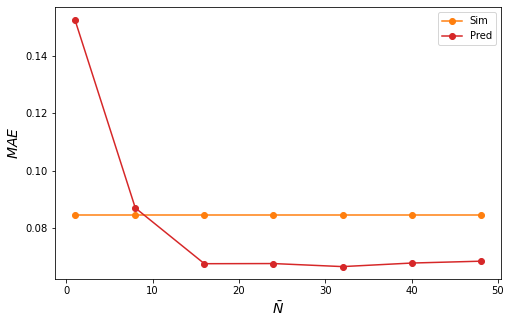

In [141]:
fig = plt.figure(figsize=(8,5))
plt.plot(predNN, avgSimDists, color='C1', marker='o', label="Sim")
plt.plot(predNN, avgPredDists, color='C3', marker='o', label="Pred")
plt.xlabel(r'$\bar{N}$',fontsize=14)
plt.ylabel(r'$MAE$',fontsize=14)
plt.legend()
plt.show()
fig.savefig(plotNames['DIST'], bbox_inches='tight')

# Calculate predictions on syntethic data

In [142]:
recalculate = True
# recalculate = False
if recalculate:
    # dataset = 'train'
    # dataset = 'valid'
    dataset = 'test'

    sample = 0

    synData = np.load("data/dataset32MCRnew10000.npz")
    synSplit = np.load("data/dataset32MCRnew10000-split.npz")

    synCoh = synData['coh']
    synPar = synData['par']

    synCoh = synCoh[synSplit[dataset]]
    synPar = synPar[synSplit[dataset]]

    np.savez("data/dataset32MCnoB-experimental2021test.npz", coh=synCoh[sample].reshape(1,7,50), par=synPar[sample].reshape(1,1,4).repeat(7, axis=1))

In [143]:
# pred = runExperimentalPredictions.run("configMCRnew2L2Test")
# pred = runExperimentalPredictions.run("configMCRnew2L2_10kTest")
# pred = runExperimentalPredictions.run("configMCRnew2L2normTest")
# pred = runExperimentalPredictions.run("configMCRnew2L2norm10kTest")
# pred = runExperimentalPredictions.run("configMCRnew2bL2normTest")
# pred = runExperimentalPredictions.run("configMCRnew2bL2norm10kTest")
#============================
# pred = [
#     runExperimentalPredictions.run("configMCRnew2cL2normTest"),
#     runExperimentalPredictions.run("configMCRnew2bL2normTest"),
#     runExperimentalPredictions.run("configMCRnew2b3L2normTest"), #some err
#     runExperimentalPredictions.run("configMCRnew2b4L2normTest"),
#     runExperimentalPredictions.run("configMCRnew2b5L2normTest"),
#     runExperimentalPredictions.run("configMCRnew2b6L2normTest"),
#     runExperimentalPredictions.run("configMCRnew2L2normTest"),
# ]
# plotNames = {
#     "L" : "plots/synL.pdf",
#     "MAE" : "plots/synMAE.pdf",
#     "MAEf" : "plots/synMAEf.pdf",
#     "SC" : "plots/synSC-N{}.pdf",
#     "DIST" : "plots/synDist.pdf",
# }
#============================
pred = [
    runExperimentalPredictions.run("configMCRnew2cL2norm10kTest"),
    runExperimentalPredictions.run("configMCRnew2bL2norm10kTest"),
    runExperimentalPredictions.run("configMCRnew2b3L2norm10kTest"),
    runExperimentalPredictions.run("configMCRnew2b4L2norm10kTest"),
    runExperimentalPredictions.run("configMCRnew2b5L2norm10kTest"),
    runExperimentalPredictions.run("configMCRnew2b6L2norm10kTest"),
    runExperimentalPredictions.run("configMCRnew2L2norm10kTest"),
    ]
plotNames = {
    "L" : "plots/synL10k.pdf",
    "MAE" : "plots/synMAE10k.pdf",
    "MAEf" : "plots/synMAEf10k.pdf",
    "SC" : "plots/synSC10k-N{}.pdf",
    "DIST" : "plots/synDist10k.pdf",
}


In [144]:
pred = np.array([[pred[i][0, 0], pred[i][0, 1], 403.2, pred[i][0, 2]] for i in range(len(pred))])

In [145]:
expData = np.load("data/dataset32MCnoB-experimental2021test.npz")

expCoh = expData['coh'][0]
expPar = expData['par'][0,0]

In [146]:
pred.shape

(7, 4)

In [147]:
print(expPar)
print(pred)

[3.4876117e-03 6.7705071e-01 4.0316669e+02 2.7605763e-03]
[[2.21097190e-03 5.06479502e-01 4.03200000e+02 5.54517750e-03]
 [3.15477583e-03 5.00195146e-01 4.03200000e+02 4.02527489e-03]
 [3.41695012e-03 6.15158081e-01 4.03200000e+02 3.16636707e-03]
 [3.29379272e-03 6.14532471e-01 4.03200000e+02 3.12326569e-03]
 [3.49870115e-03 6.49442971e-01 4.03200000e+02 2.92380550e-03]
 [3.56696313e-03 6.65091872e-01 4.03200000e+02 2.83641950e-03]
 [3.54450266e-03 6.78678334e-01 4.03200000e+02 2.83811940e-03]]


/home/trianam/Progetti/nvSensing/calculate_chi_func.py:51: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = np.abs(quad( lambda x: np.abs(funcNoise(x,*para)*Fn(x,t)/(np.pi*x**2)), 0.001, 8.5)) # integrate from ω=0.001 to ω=8.5


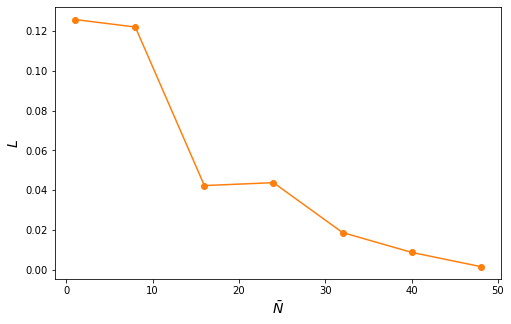

In [148]:
predNN, _, _ = createCoh(pred[0,0], pred[0,1], pred[0,2], pred[0,3])

fig = plt.figure(figsize=(8,5))
plt.plot(predNN, [L(pred[i], expPar) for i in range(len(pred))], color='C1', marker='o')
plt.xlabel(r'$\bar{N}$',fontsize=14)
plt.ylabel(r'$L$',fontsize=14)
plt.show()
fig.savefig(plotNames['L'], bbox_inches='tight')

In [149]:
# [0.1282835913465824, 0.17674736006464808, 0.03808254455961287, 0.03637134568206966, 0.04327287242282182, 0.037513683185447004, 0.026979702149052175

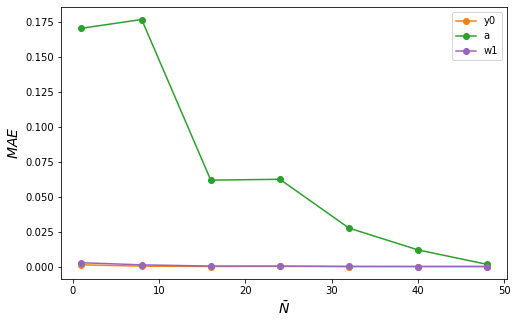

In [150]:
fig = plt.figure(figsize=(8,5))
plt.plot(predNN, [np.abs(pred[i][0] - expPar[0]) for i in range(len(pred))], color='C1', marker='o', label="y0")
plt.plot(predNN, [np.abs(pred[i][1] - expPar[1]) for i in range(len(pred))], color='C2', marker='o', label="a")
# plt.plot(predNN, [np.abs(pred[i][2] - expPar[2]) for i in range(len(pred))], color='C3', marker='o', label="B")
plt.plot(predNN, [np.abs(pred[i][3] - expPar[3]) for i in range(len(pred))], color='C4', marker='o', label="w1")
plt.xlabel(r'$\bar{N}$',fontsize=14)
plt.ylabel(r'$MAE$',fontsize=14)
plt.legend()
plt.show()
fig.savefig(plotNames['MAEf'], bbox_inches='tight')

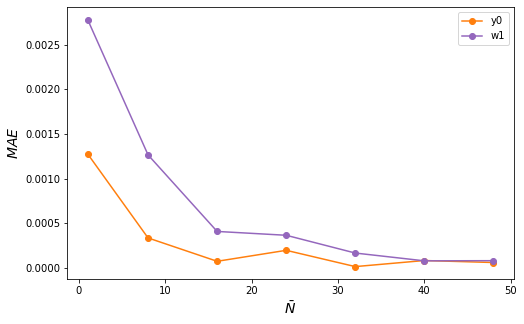

In [151]:
fig = plt.figure(figsize=(8,5))
plt.plot(predNN, [np.abs(pred[i][0] - expPar[0]) for i in range(len(pred))], color='C1', marker='o', label="y0")
# plt.plot(predNN, [np.abs(pred[i][1] - expPar[1]) for i in range(len(pred))], color='C2', marker='o', label="a")
# plt.plot(predNN, [np.abs(pred[i][2] - expPar[2]) for i in range(len(pred))], color='C3', marker='o', label="B")
plt.plot(predNN, [np.abs(pred[i][3] - expPar[3]) for i in range(len(pred))], color='C4', marker='o', label="w1")
plt.xlabel(r'$\bar{N}$',fontsize=14)
plt.ylabel(r'$MAE$',fontsize=14)
plt.legend()
plt.show()
fig.savefig(plotNames['MAE'], bbox_inches='tight')

/home/trianam/Progetti/nvSensing/calculate_chi_func.py:51: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = np.abs(quad( lambda x: np.abs(funcNoise(x,*para)*Fn(x,t)/(np.pi*x**2)), 0.001, 8.5)) # integrate from ω=0.001 to ω=8.5


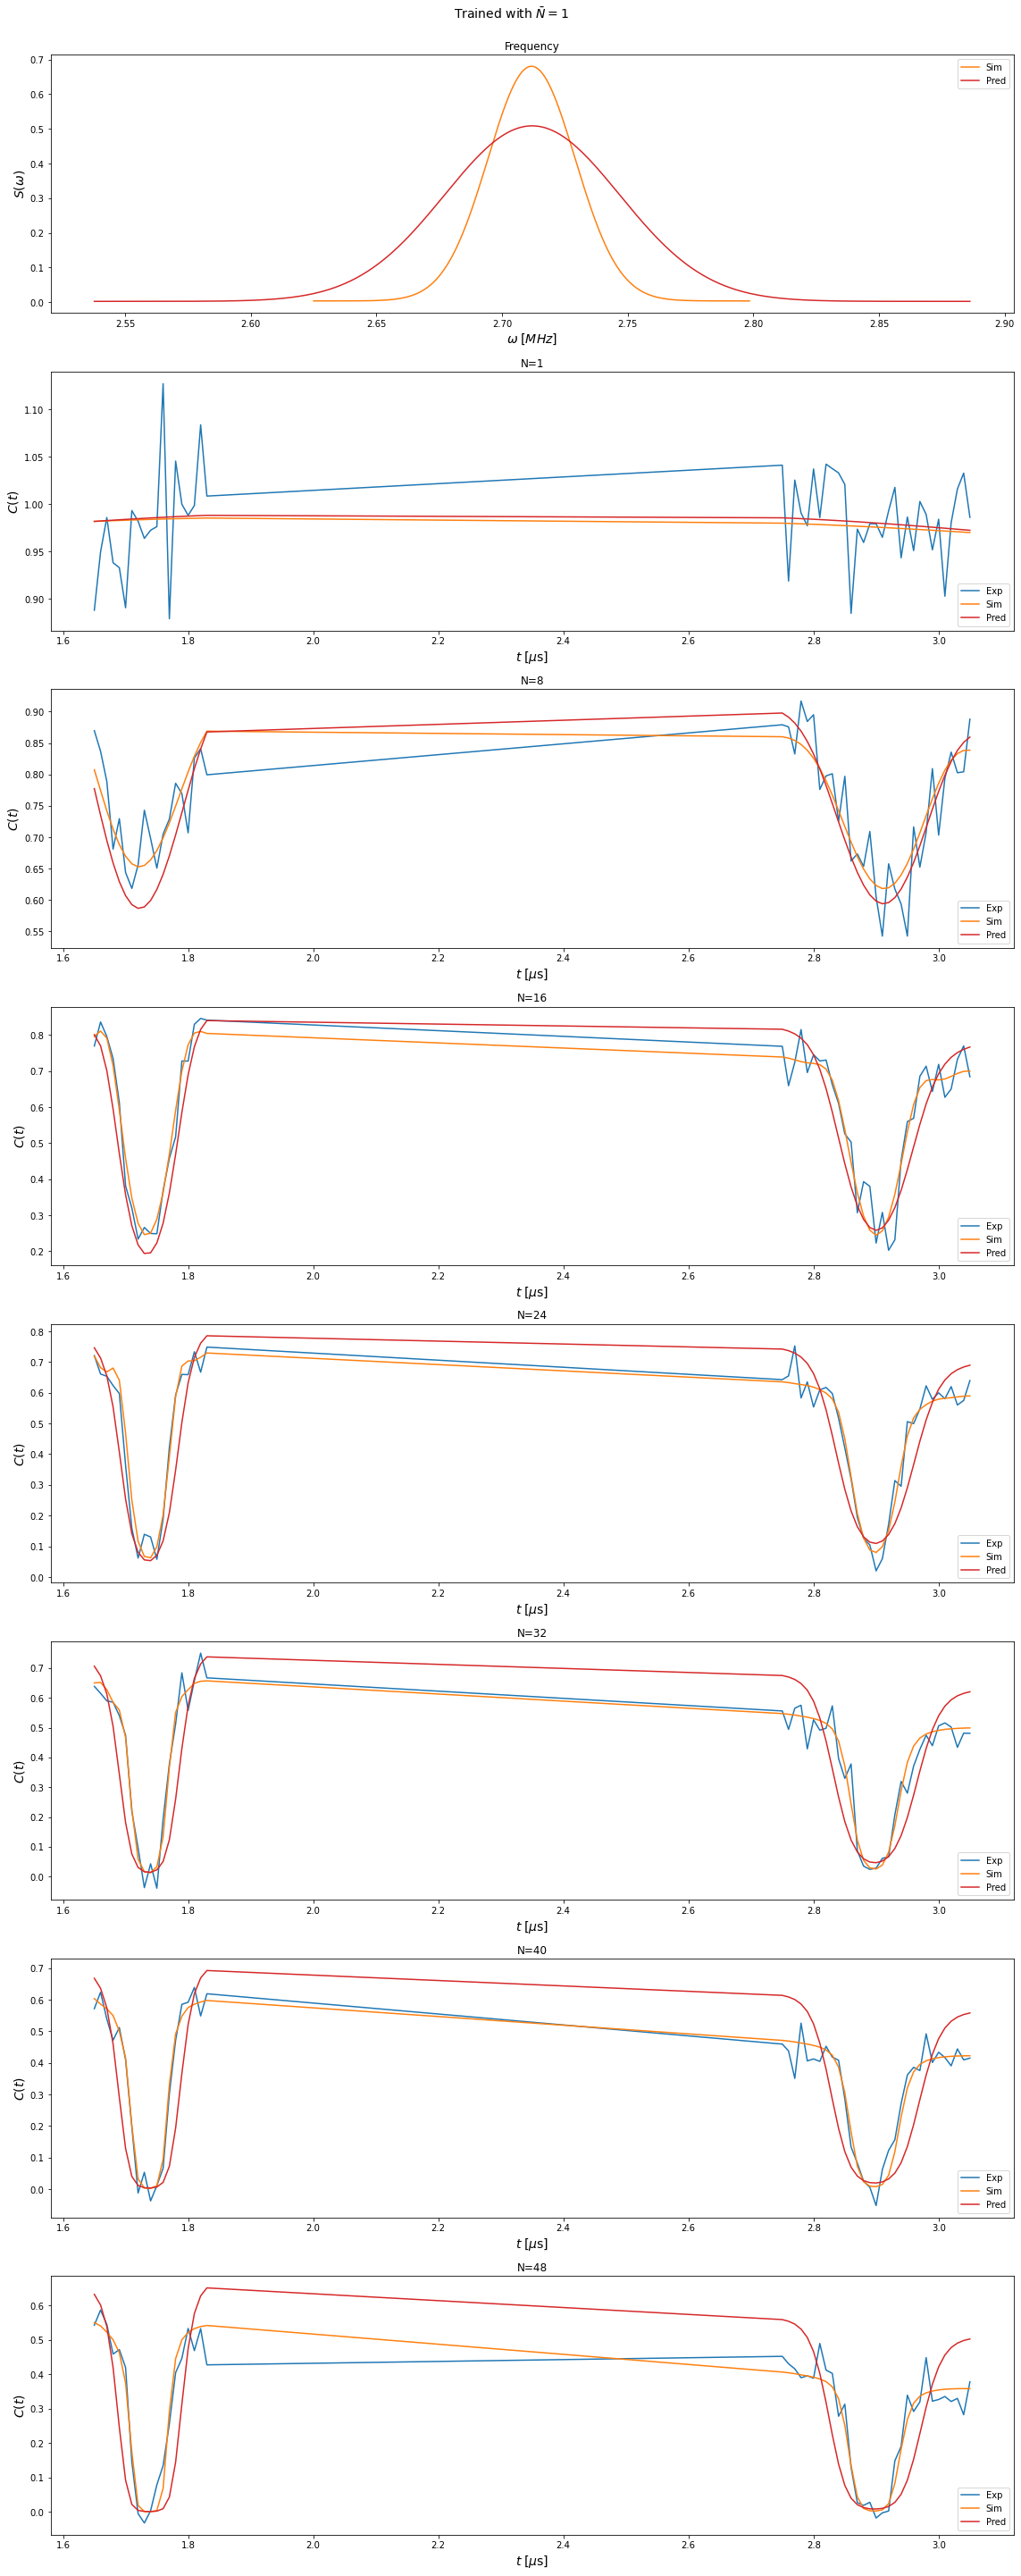

/home/trianam/Progetti/nvSensing/calculate_chi_func.py:51: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = np.abs(quad( lambda x: np.abs(funcNoise(x,*para)*Fn(x,t)/(np.pi*x**2)), 0.001, 8.5)) # integrate from ω=0.001 to ω=8.5


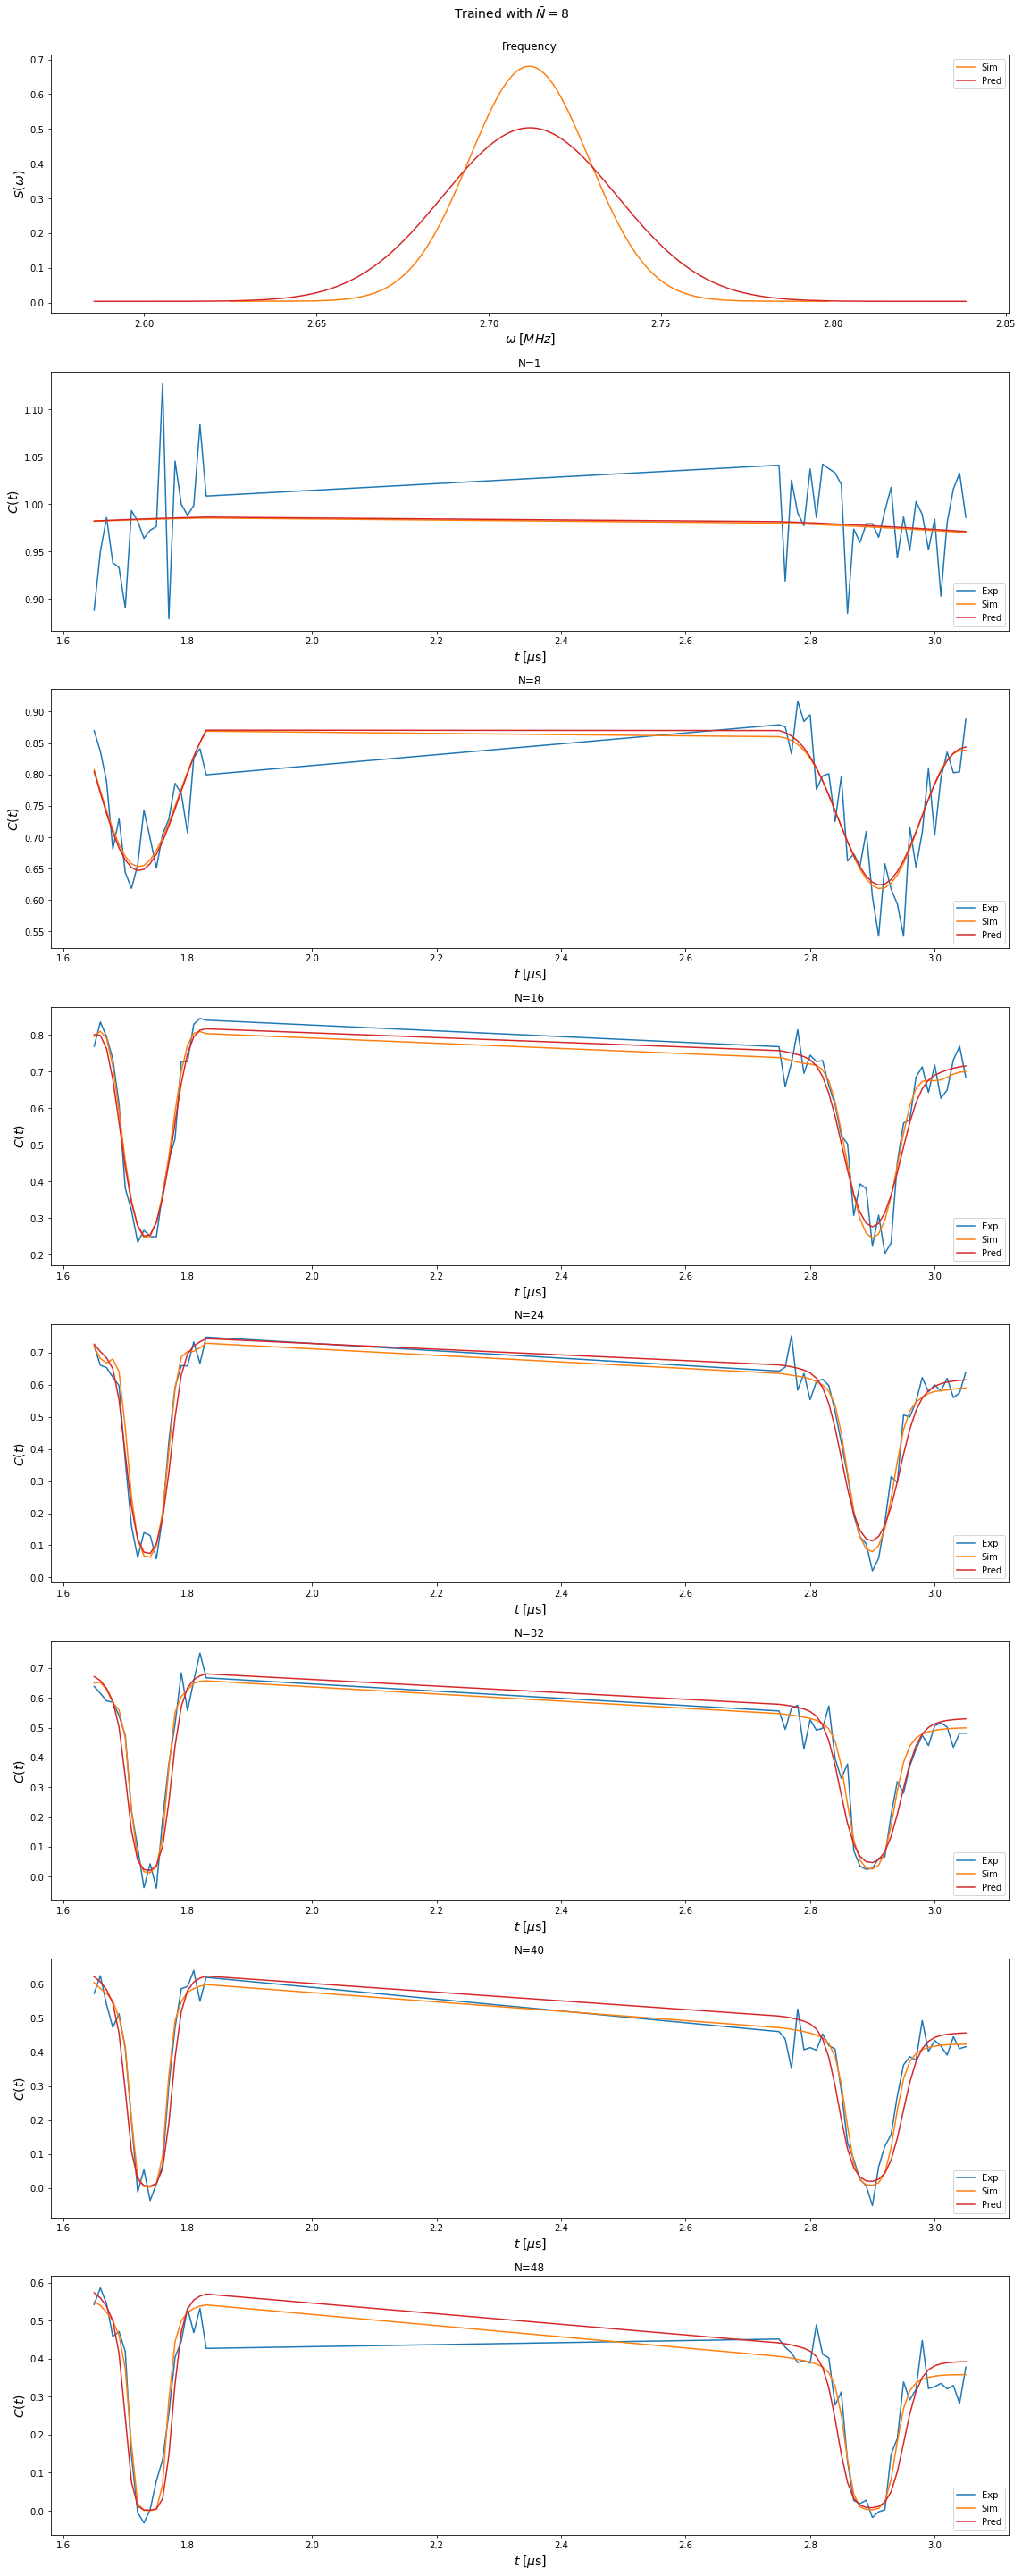

/home/trianam/Progetti/nvSensing/calculate_chi_func.py:51: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = np.abs(quad( lambda x: np.abs(funcNoise(x,*para)*Fn(x,t)/(np.pi*x**2)), 0.001, 8.5)) # integrate from ω=0.001 to ω=8.5


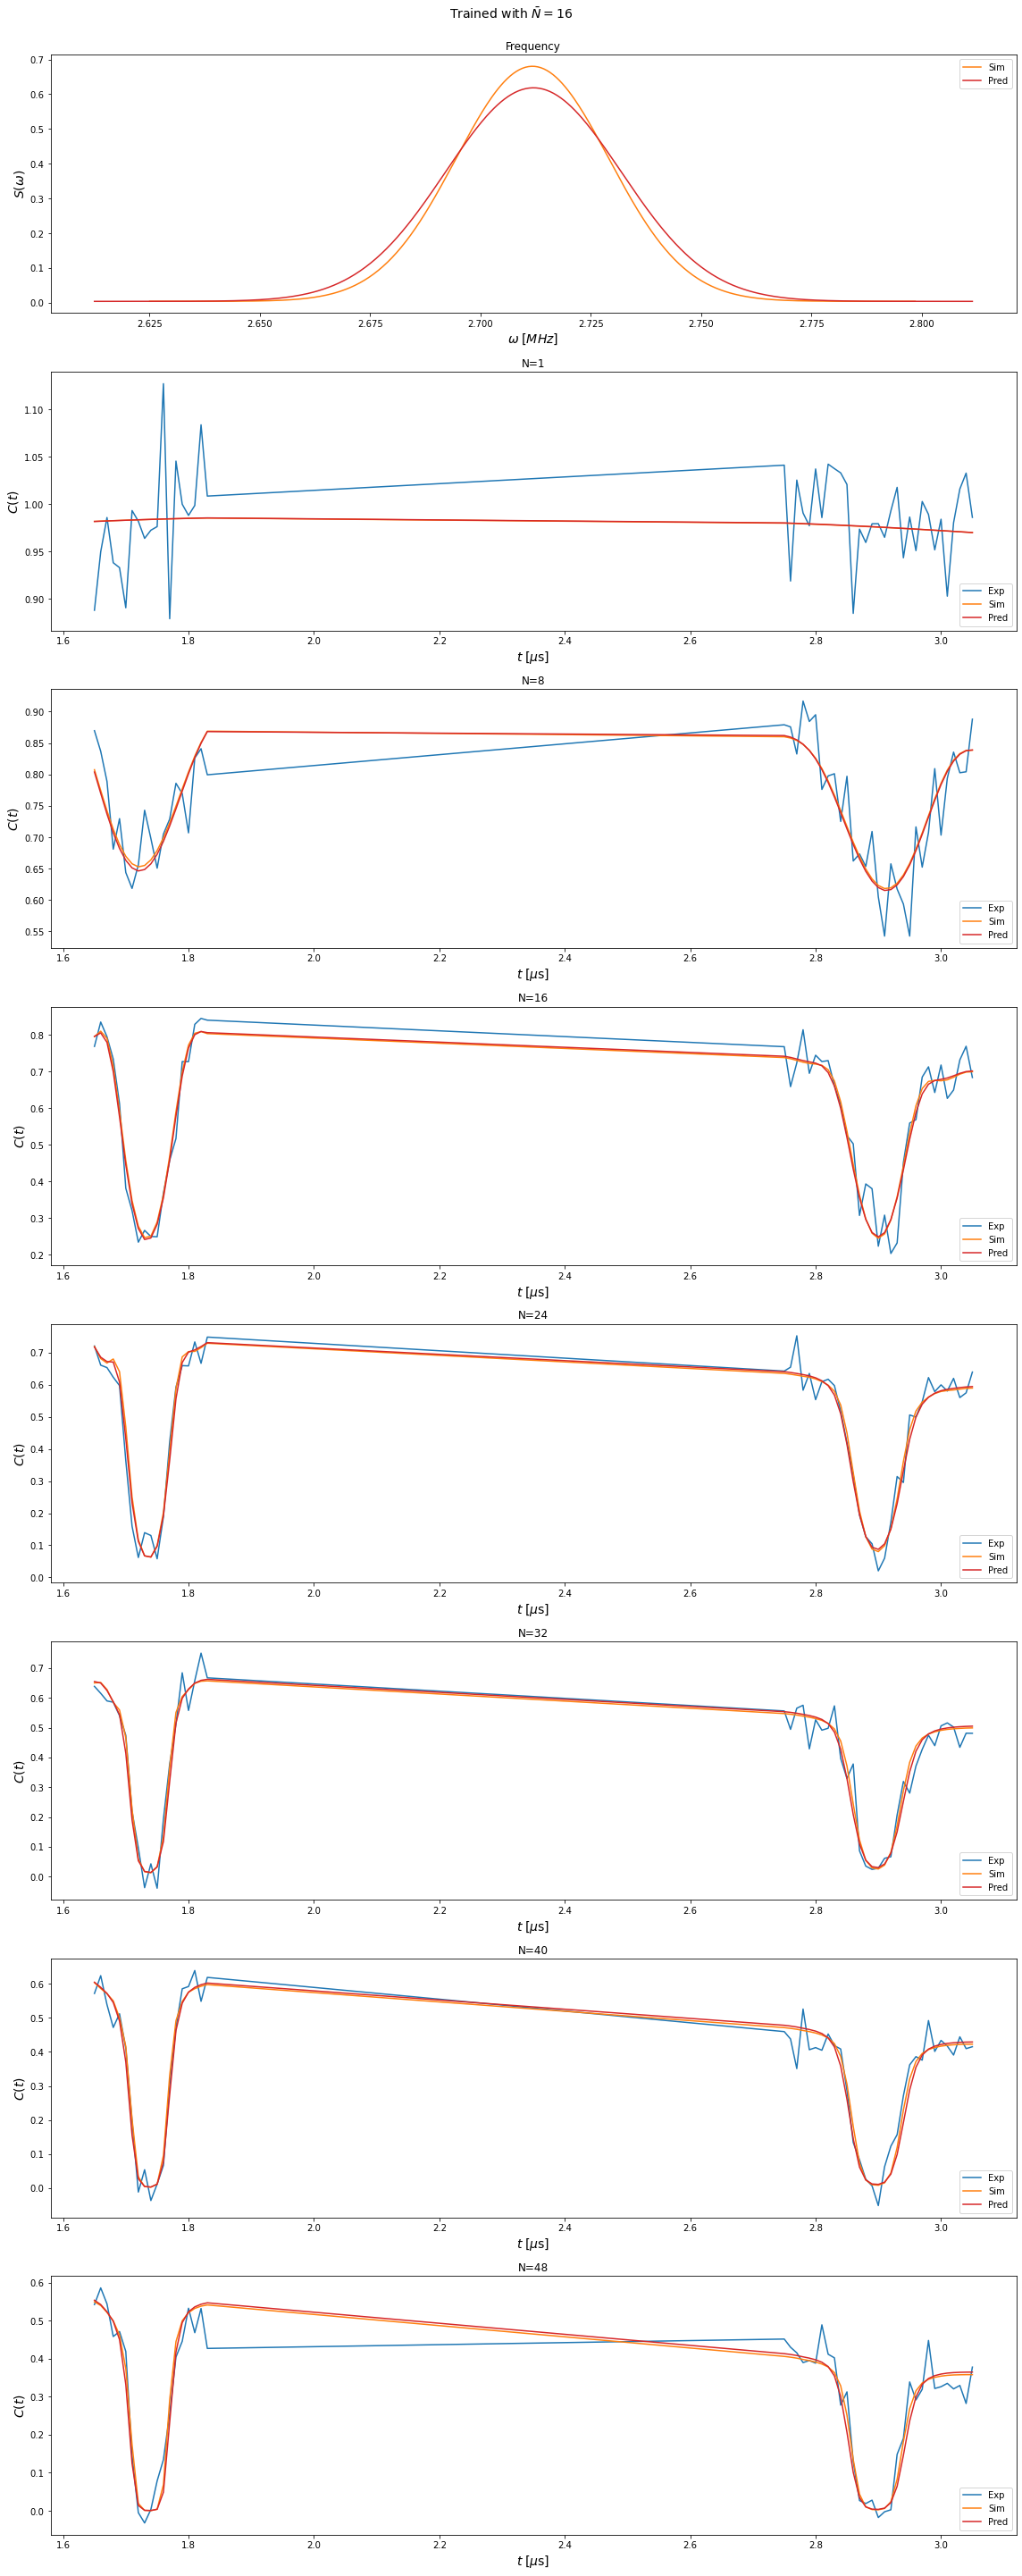

/home/trianam/Progetti/nvSensing/calculate_chi_func.py:51: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = np.abs(quad( lambda x: np.abs(funcNoise(x,*para)*Fn(x,t)/(np.pi*x**2)), 0.001, 8.5)) # integrate from ω=0.001 to ω=8.5


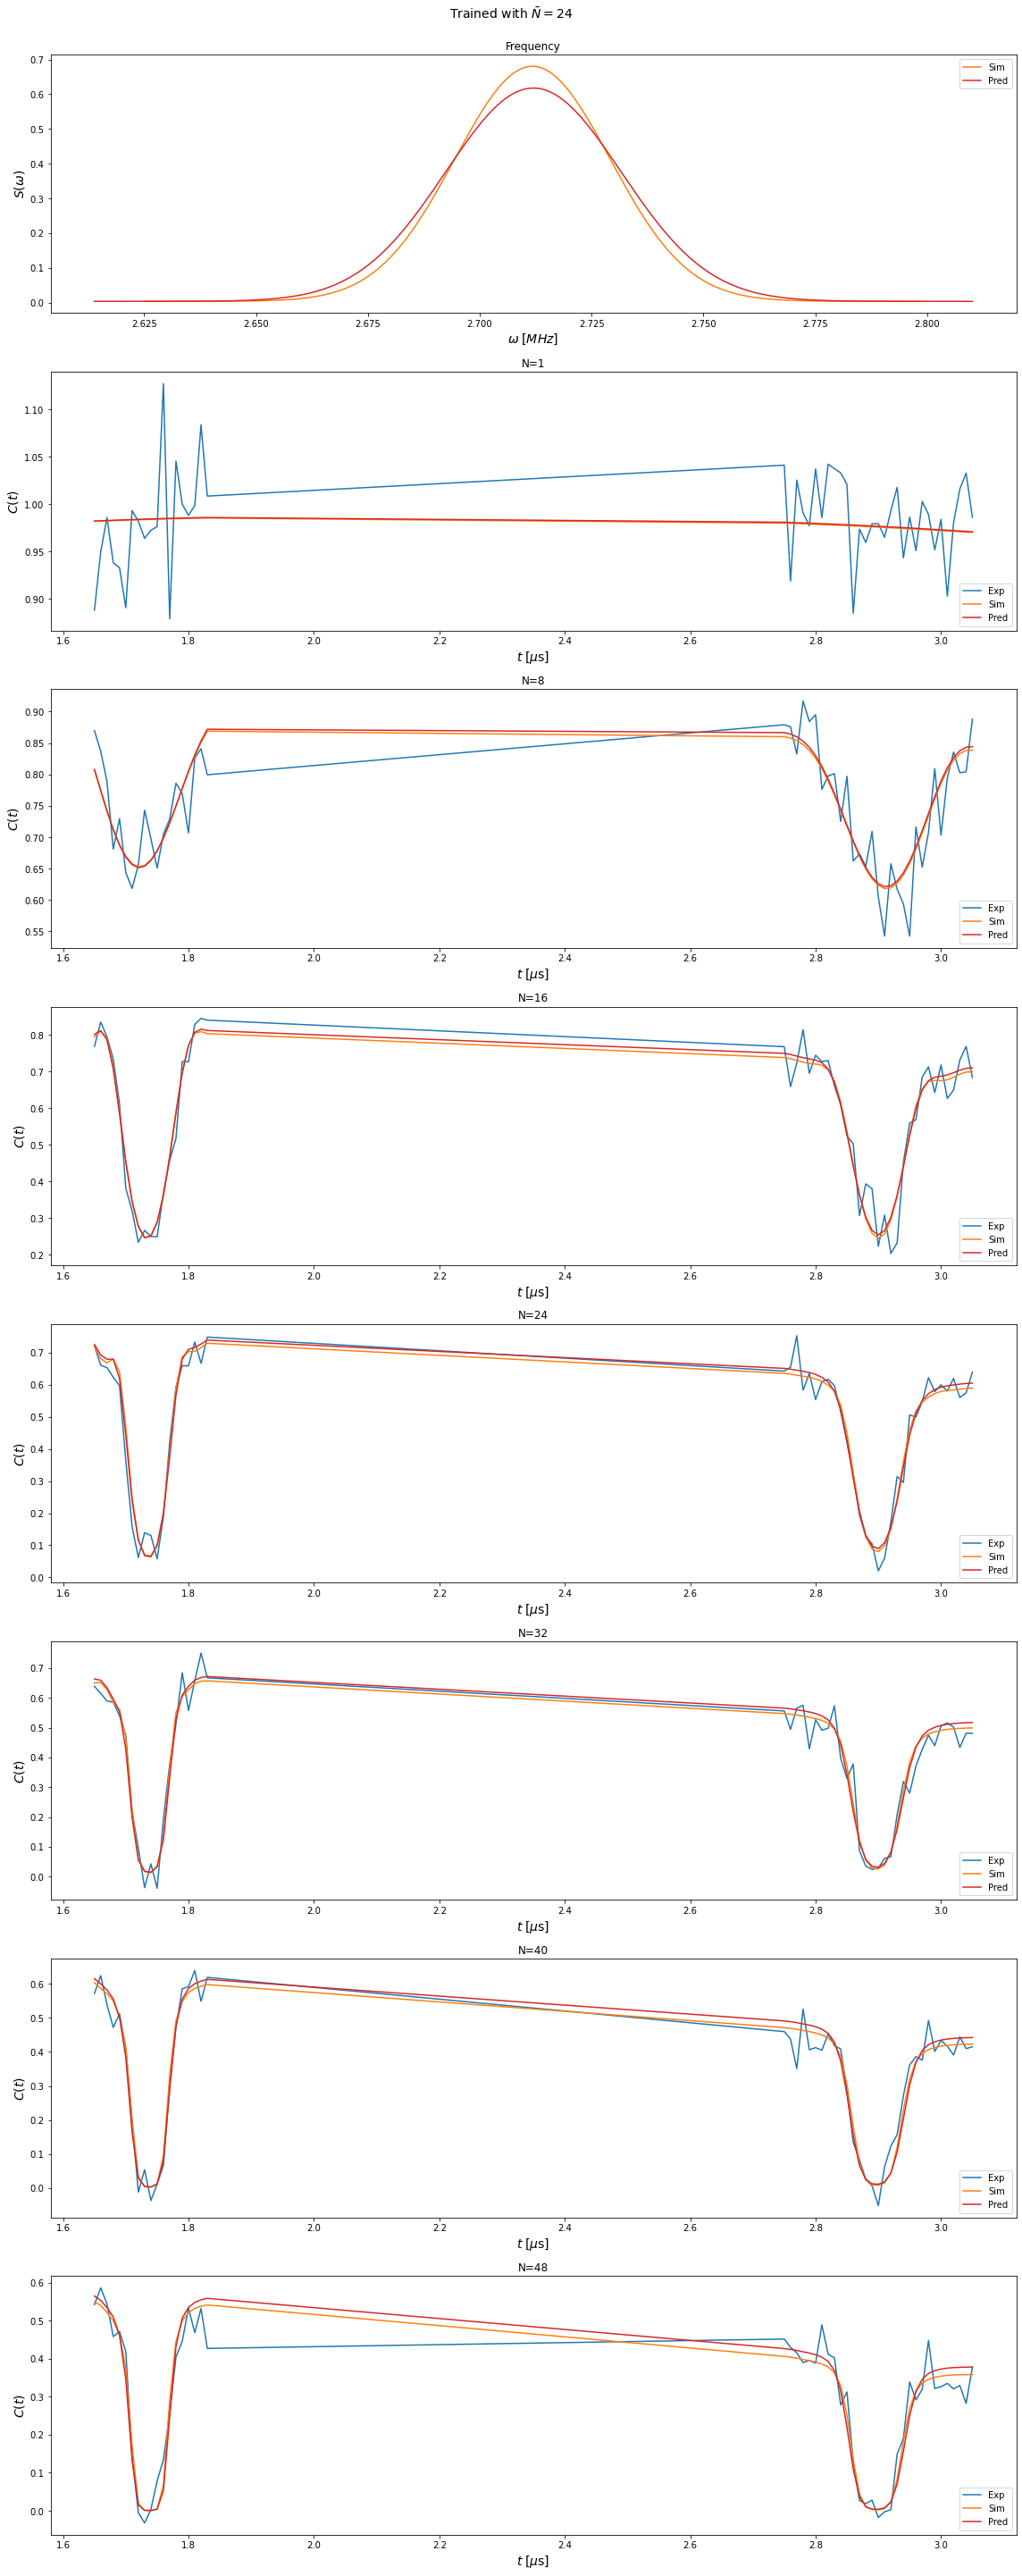

/home/trianam/Progetti/nvSensing/calculate_chi_func.py:51: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = np.abs(quad( lambda x: np.abs(funcNoise(x,*para)*Fn(x,t)/(np.pi*x**2)), 0.001, 8.5)) # integrate from ω=0.001 to ω=8.5


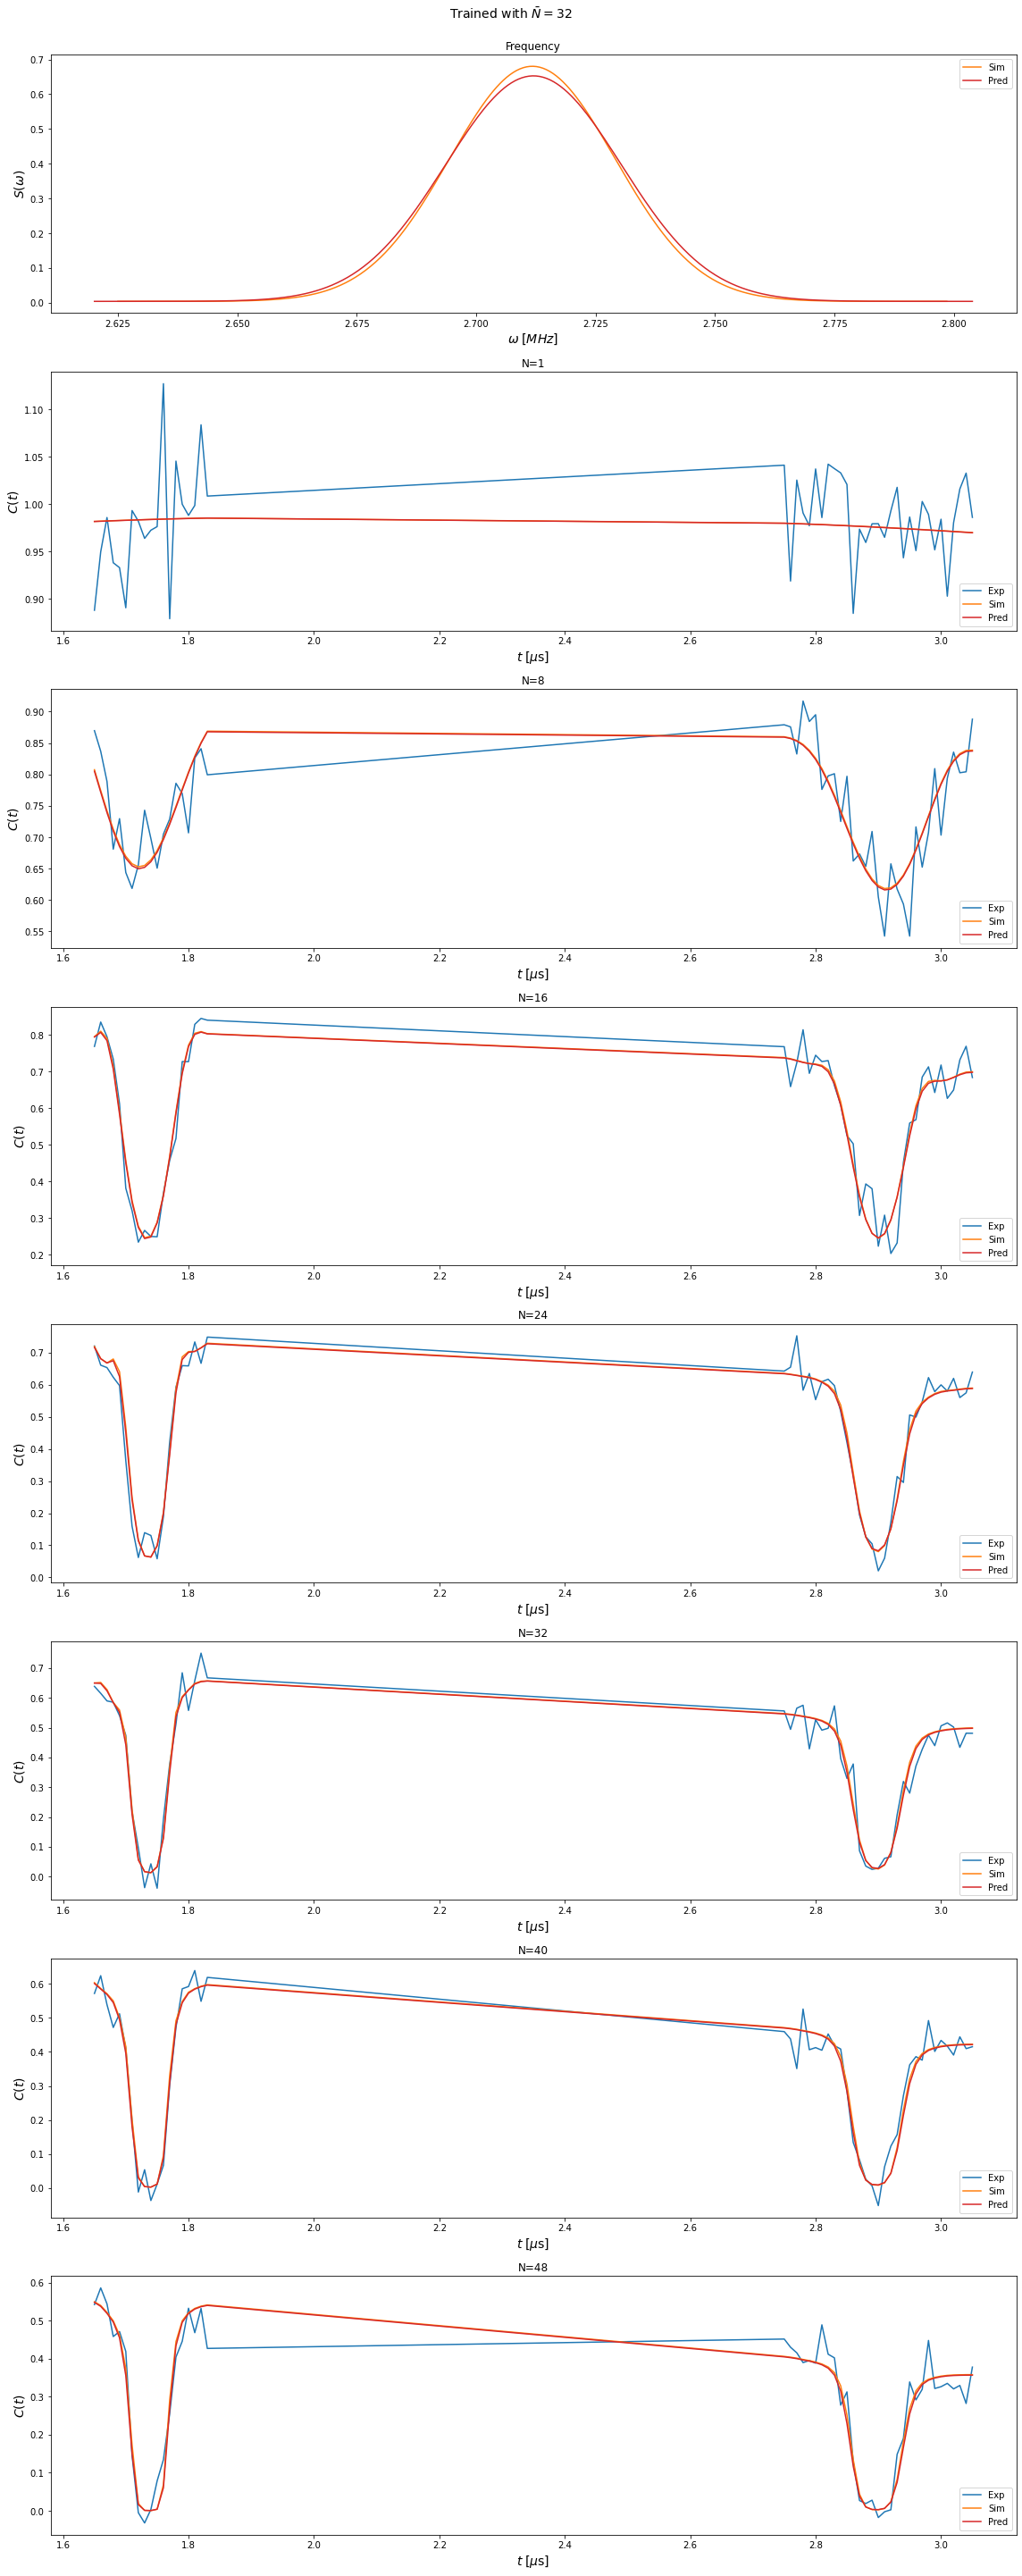

/home/trianam/Progetti/nvSensing/calculate_chi_func.py:51: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = np.abs(quad( lambda x: np.abs(funcNoise(x,*para)*Fn(x,t)/(np.pi*x**2)), 0.001, 8.5)) # integrate from ω=0.001 to ω=8.5


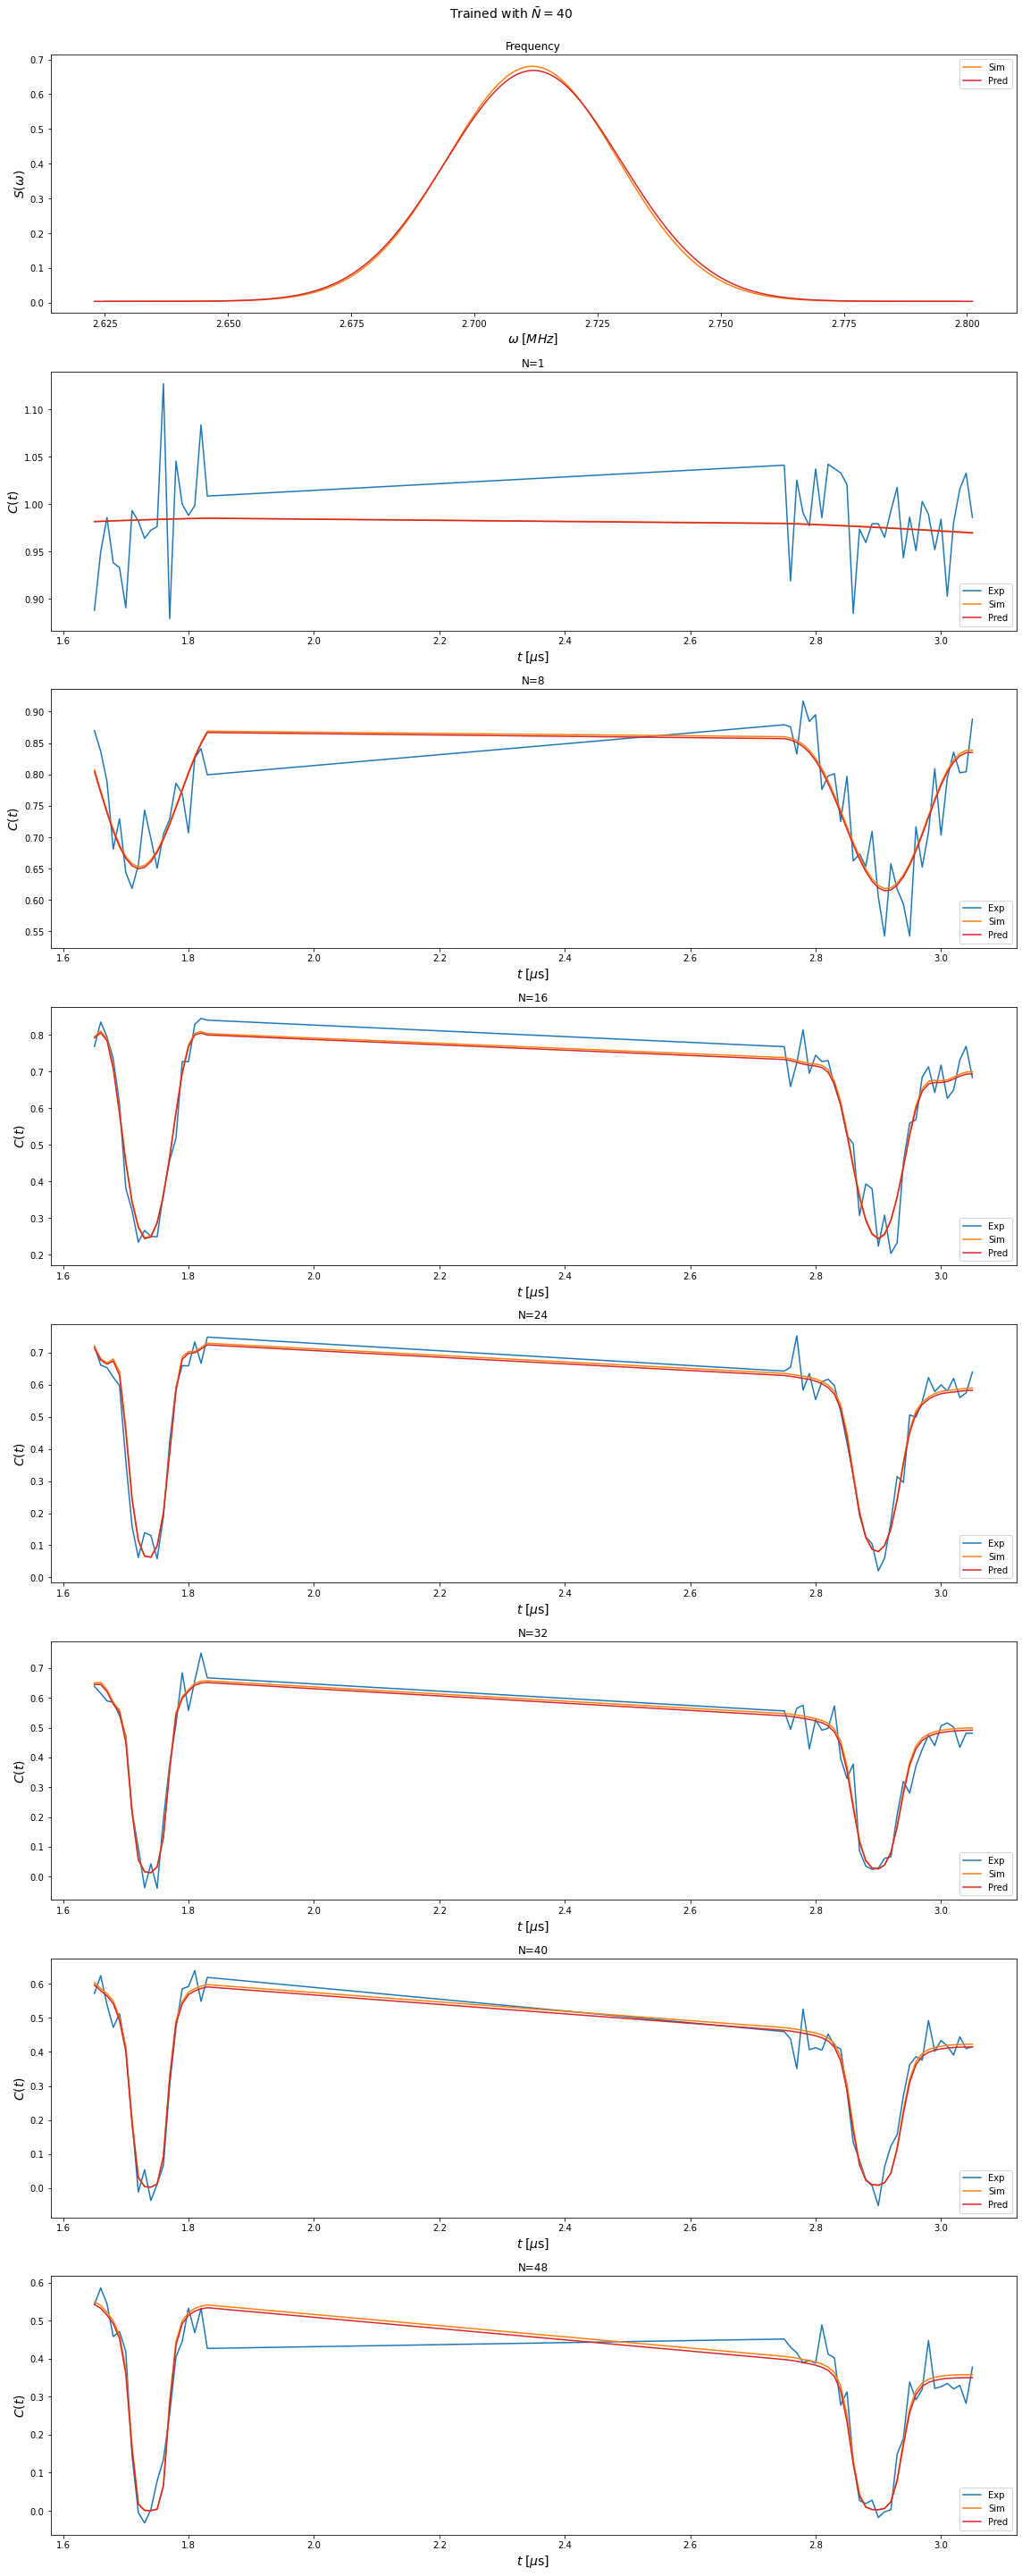

/home/trianam/Progetti/nvSensing/calculate_chi_func.py:51: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = np.abs(quad( lambda x: np.abs(funcNoise(x,*para)*Fn(x,t)/(np.pi*x**2)), 0.001, 8.5)) # integrate from ω=0.001 to ω=8.5


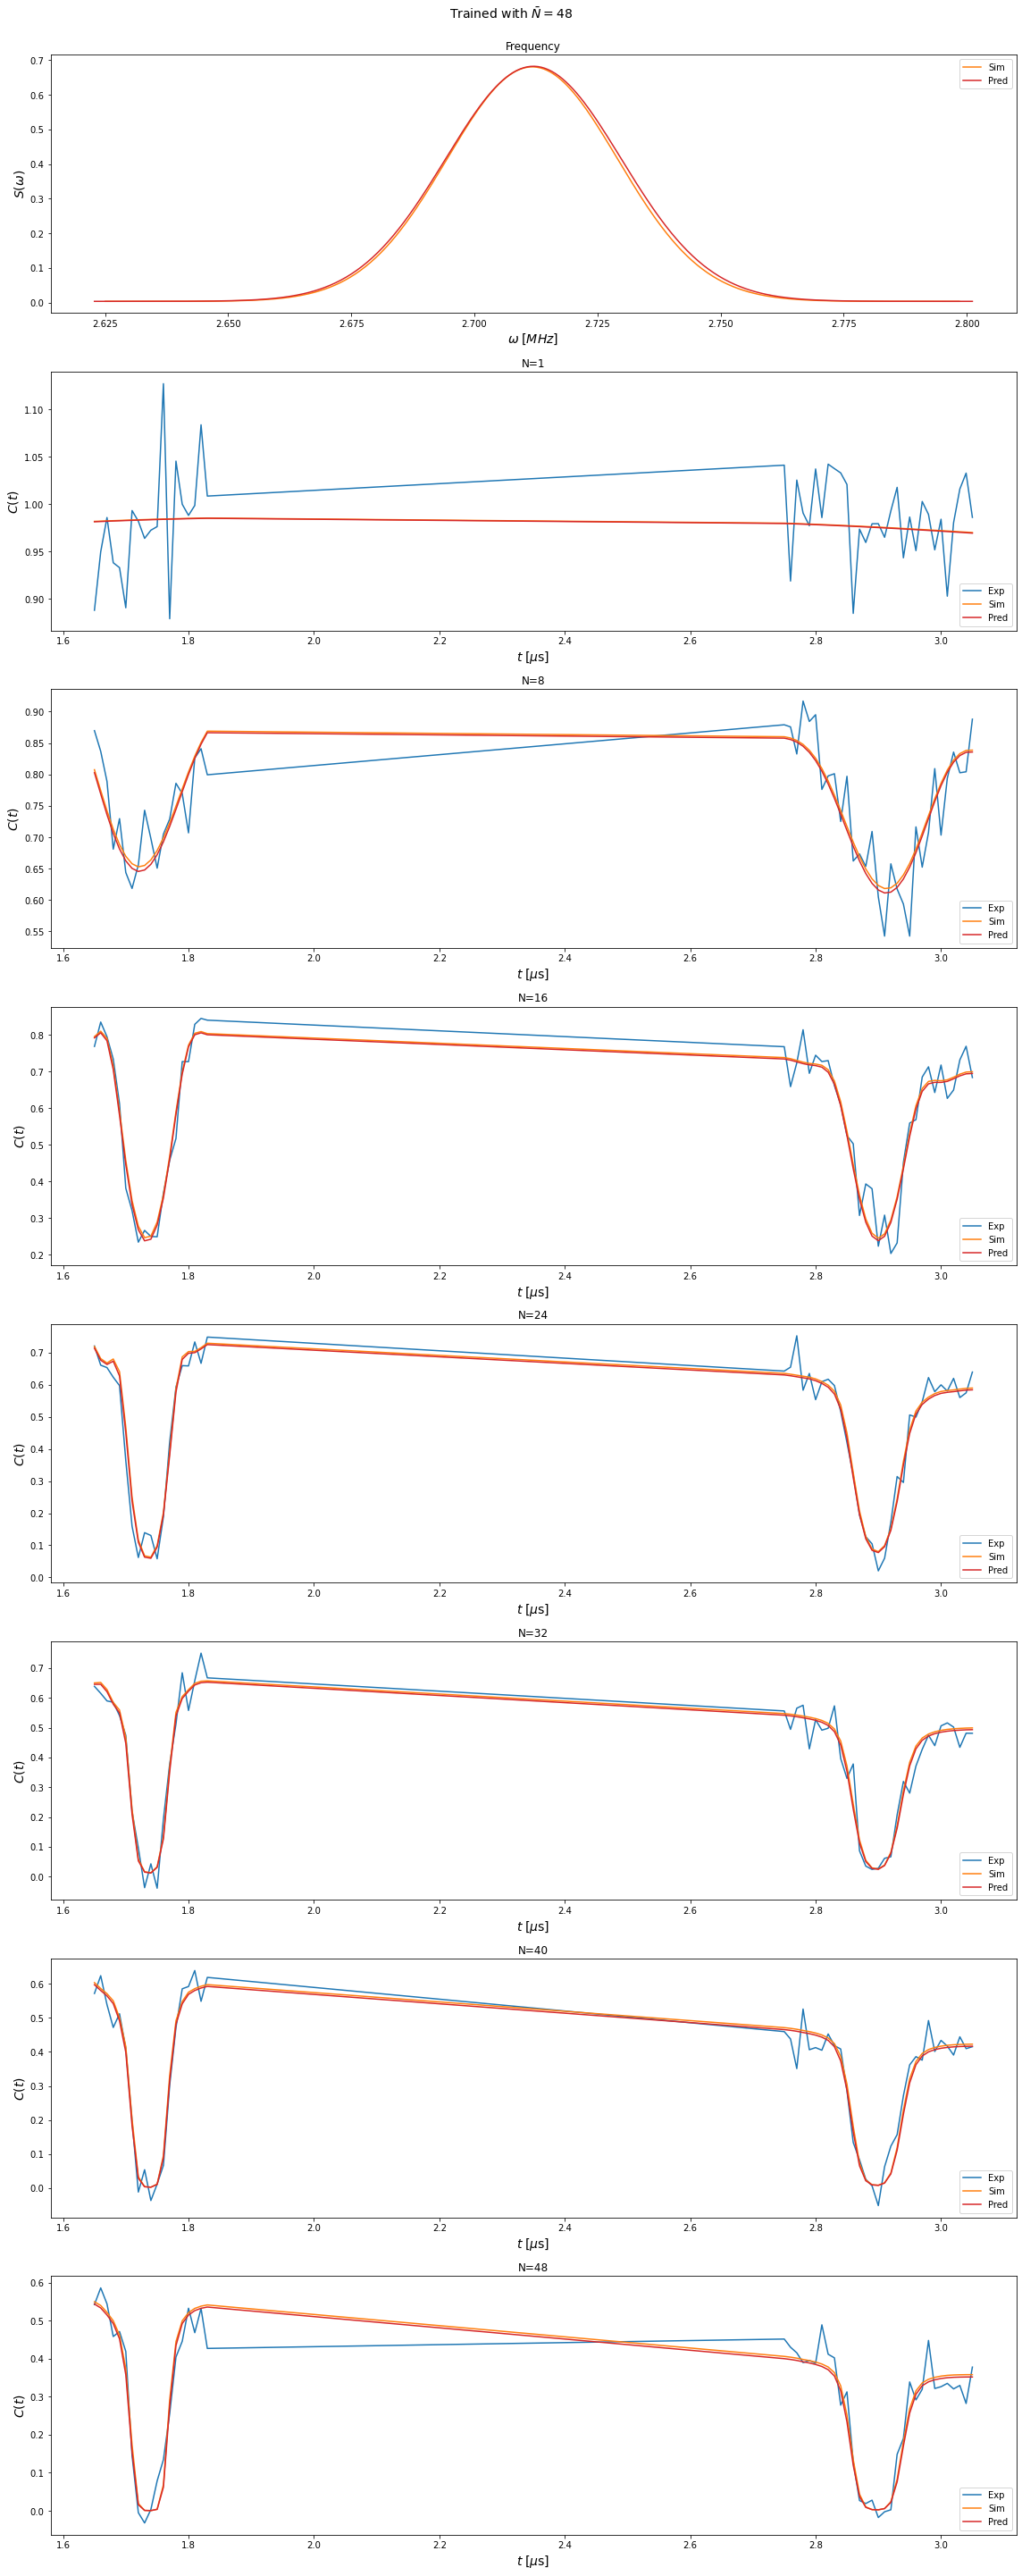

In [152]:
# noiseSD = 0.05
noiseSD = None

simNN, simT1, simCoh = createCoh(expPar[0], expPar[1], expPar[2], expPar[3], noiseSD)
simNNC, simT1C, simCohC = createCoh(expPar[0], expPar[1], 403.2, expPar[3], noiseSD)

avgSimDists = []
avgPredDists = []
for Nb in range(len(pred)):
    predNN, predT1, predCoh = createCoh(pred[Nb,0], pred[Nb,1], pred[Nb,2], pred[Nb,3], noiseSD)

    expO, expS = createS(expPar[0], expPar[1], expPar[2], expPar[3])
    predO, predS = createS(pred[Nb,0], pred[Nb,1], pred[Nb,2], pred[Nb,3])

    fig, axes = plt.subplots(1+len(simCoh), 1, figsize=(16,5*(1+len(simCoh))))
    # fig.subplots_adjust(top=0.8)
    fig.suptitle(r'Trained with $\bar{{N}}={}$'.format(simNN[Nb]), fontsize=14, y=1)

    axes[0].plot(expO, expS, label="Sim", color='C1')
    axes[0].plot(predO, predS, label="Pred", color='C3')
    axes[0].set_title("Frequency")
    axes[0].set_xlabel(r'$\omega \; [MHz]$',fontsize=14)
    axes[0].set_ylabel(r'$S(\omega)$',fontsize=14)
    axes[0].legend(loc='upper right')

    avgSimDist = 0
    avgPredDist = 0
    avgDistNum = 0
    for N in range(len(simCoh)):
        # fig = plt.figure(figsize=(16,5))
        axes[N+1].plot(simT1, expCoh[N], label="Exp", color='C0') #use same T1
        axes[N+1].plot(simT1, simCoh[N], label="Sim", color='C1')
        axes[N+1].plot(predT1, predCoh[N], label="Pred", color='C3')
        axes[N+1].legend(loc='lower right')
        axes[N+1].set_title("N={}".format(simNN[N]))
        axes[N+1].set_xlabel(r'$t \; [\mu{\rm s}]$',fontsize=14)
        axes[N+1].set_ylabel(r'$C(t)$',fontsize=14)
        for t in range(len(simT1)):
            avgSimDist += np.abs(expCoh[N][t]-simCoh[N][t])
            avgPredDist += np.abs(expCoh[N][t]-predCoh[N][t])
            avgDistNum += 1
    avgSimDists.append(avgSimDist/avgDistNum)
    avgPredDists.append(avgPredDist/avgDistNum)
    fig.tight_layout()
    plt.show()
    fig.savefig(plotNames['SC'].format(Nb), bbox_inches='tight')

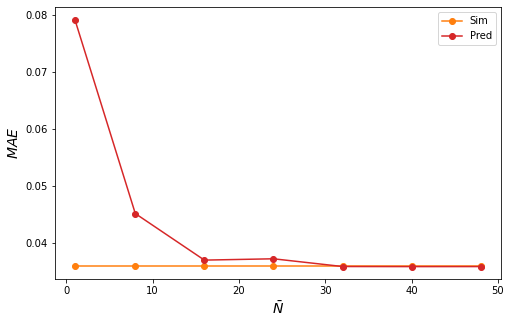

In [153]:
fig = plt.figure(figsize=(8,5))
plt.plot(predNN, avgSimDists, color='C1', marker='o', label="Sim")
plt.plot(predNN, avgPredDists, color='C3', marker='o', label="Pred")
plt.xlabel(r'$\bar{N}$',fontsize=14)
plt.ylabel(r'$MAE$',fontsize=14)
plt.legend()
plt.show()
fig.savefig(plotNames['DIST'], bbox_inches='tight')

# Predict on all synthetic test set

In [160]:
recalculate = True
# recalculate = False
if recalculate:
    # dataset = 'train'
    # dataset = 'valid'
    dataset = 'test'

    sample = 0

    synData = np.load("data/dataset32MCRnew10000.npz")
    synSplit = np.load("data/dataset32MCRnew10000-split.npz")

    synCoh = synData['coh']
    synPar = synData['par']

    synCoh = synCoh[synSplit[dataset]]
    synPar = synPar[synSplit[dataset]]

    np.savez("data/dataset32MCnoB-experimental2021test.npz", coh=synCoh,
             par=synPar)


In [161]:
# pred = runExperimentalPredictions.run("configMCRnew2L2Test")
# pred = runExperimentalPredictions.run("configMCRnew2L2_10kTest")
# pred = runExperimentalPredictions.run("configMCRnew2L2normTest")
# pred = runExperimentalPredictions.run("configMCRnew2L2norm10kTest")
# pred = runExperimentalPredictions.run("configMCRnew2bL2normTest")
# pred = runExperimentalPredictions.run("configMCRnew2bL2norm10kTest")
#============================
# pred = [
#     runExperimentalPredictions.run("configMCRnew2cL2normTest"),
#     runExperimentalPredictions.run("configMCRnew2bL2normTest"),
#     runExperimentalPredictions.run("configMCRnew2b3L2normTest"), #some err
#     runExperimentalPredictions.run("configMCRnew2b4L2normTest"),
#     runExperimentalPredictions.run("configMCRnew2b5L2normTest"),
#     runExperimentalPredictions.run("configMCRnew2b6L2normTest"),
#     runExperimentalPredictions.run("configMCRnew2L2normTest"),
# ]
# plotNames = {
#     "L" : "plots/synL.pdf",
#     "MAE" : "plots/synMAE.pdf",
#     "MAEf" : "plots/synMAEf.pdf",
#     "SC" : "plots/synSC-N{}.pdf",
#     "DIST" : "plots/synDist.pdf",
# }
#============================
pred = [
    runExperimentalPredictions.run("configMCRnew2cL2norm10kTest"),
    runExperimentalPredictions.run("configMCRnew2bL2norm10kTest"),
    runExperimentalPredictions.run("configMCRnew2b3L2norm10kTest"),
    runExperimentalPredictions.run("configMCRnew2b4L2norm10kTest"),
    runExperimentalPredictions.run("configMCRnew2b5L2norm10kTest"),
    runExperimentalPredictions.run("configMCRnew2b6L2norm10kTest"),
    runExperimentalPredictions.run("configMCRnew2L2norm10kTest"),
]
plotNames = {
    "L": "plots/synL10k.pdf",
    "MAE": "plots/synMAE10k.pdf",
    "MAEf": "plots/synMAEf10k.pdf",
    "SC": "plots/synSC10k-N{}.pdf",
    "DIST": "plots/synDist10k.pdf",
}

In [166]:
predd = np.array([[[pred[n][i, 0], pred[n][i, 1], 403.2, pred[n][i, 2]] for n in range(len(pred))] for i in range(len(pred[0]))])

In [167]:
predd.shape

(2000, 7, 4)

In [169]:
data = np.load("data/dataset32MCnoB-experimental2021test.npz")

In [171]:
data['coh'].shape

(2000, 7, 50)

In [172]:
data['par'].shape

(2000, 4)

In [173]:
# coh: C(t), par: real parameters, pred: ML predictions for models trained on every \bar{N}
np.savez("/tmp/synthDataPreds.npz", coh=data['coh'], par=data['par'], pred=predd)